# Prediction of Climate Change Sentiments

# Outline

This notebook is divided into the following sections:
- Introduction    
- Data PrePocessing/Cleaning
- Exploratory Data Analysis
- Modelling and Evaluation
- Final Model Selection
- Final Prediction
- Conclusion

# Problem Statement

The objective of this project is to develop a Machine Learning model that can classify whether or not a person believes in climate change using new twitter data. Providing a precise and robust solution to this task gives businesses access to a large pool of customer sentiment across numerous demographic and geographic groups, allowing them to gain new insights and better inform future marketing initiatives.

<a id='Import'></a>
# Import necessary libraries

In [1]:
from comet_ml import Experiment

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()


# imports for Natural Language  Processing
import nltk
import string
import re
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_roc_curve
import pickle



import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




In [4]:
experiment = Experiment(
    api_key="IBWK0lGRa4Pn8hpe4kRQBqTAW",
    project_name="climate-change-belief-analysis-2021",
    workspace="trsiba",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/trsiba/climate-change-belief-analysis-2021/ea50bcc5f78a44b790bd6036532dc516



<a id='Load'></a>
# Load and view the data

In [5]:
# Importing the train & test data sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test_with_no_labels.csv')

# EDA Datasets
train_eda = pd.read_csv('train.csv')
test_eda = pd.read_csv('test_with_no_labels.csv')

# Data Preprocessing

We must first undertake fundamental data pre-processing activities such as null value imputation and the removal of undesirable data before moving on to the exploration stage. The process of cleaning and preparing the text for classification is known as pre-processing the data.

In [6]:
train_data = train.copy()
test_data = test.copy()

In [7]:
#Checking if there are missing values in the Train dataset
train.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [8]:
#Checking if there are missing values in the Test dataset
test.isna().sum()

message    0
tweetid    0
dtype: int64

In [9]:
#Remove contractions
train['message'] = train['message'].apply(lambda x: contractions.fix(x))

train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: it is 2016, and a racist,...",466954


In [10]:
#Removing URLs
train['message'] = train['message'].str.replace('http\S+|www.\S+', '', case=False)

<ipython-input-10-4061fba897ce>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['message'] = train['message'].str.replace('http\S+|www.\S+', '', case=False)


In [11]:
#Removing Punctuations
def remove_punc(x):
    
    x = re.sub(r"([^A-Za-z0-9]+)"," ",x)

    return x

train['message'] = train['message'].map(lambda x: remove_punc(str(x)))

### Tokenization

A tokeniser divides text into a sequence of tokens, which roughly correspond to "words". We will use tokenisers to clean up the data, making it ready for analysis.

In [12]:
nltk.download('punkt')

train['message'] = train['message'].apply(word_tokenize)
train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,message,tweetid
0,1,"[PolySciMajor, EPA, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[RT, RawStory, Researchers, say, we, have, thr...",698562
3,1,"[TodayinMaker, WIRED, 2016, was, a, pivotal, y...",573736
4,1,"[RT, SoyNovioDeTodas, it, is, 2016, and, a, ra...",466954


In [13]:
#Removing Retweets
retweet = 'RT'
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in retweet])
train.head(10)

,sentiment,message,tweetid
0,1,"[PolySciMajor, EPA, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[RawStory, Researchers, say, we, have, three, ...",698562
3,1,"[TodayinMaker, WIRED, 2016, was, a, pivotal, y...",573736
4,1,"[SoyNovioDeTodas, it, is, 2016, and, a, racist...",466954
5,1,"[Worth, a, read, whether, you, do, or, do, not...",425577
6,1,"[thenation, Mike, Pence, does, not, believe, i...",294933
7,1,"[makeandmendlife, Six, big, things, we, can, A...",992717
8,1,"[AceofSpadesHQ, My, 8yo, nephew, is, inconsola...",664510
9,1,"[paigetweedy, no, offense, but, like, how, do,...",260471


In [14]:
#Conversion to Lower case
train['message'] = train['message'].apply(lambda x: [word.lower() for word in x])
train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[rawstory, researchers, say, we, have, three, ...",698562
3,1,"[todayinmaker, wired, 2016, was, a, pivotal, y...",573736
4,1,"[soynoviodetodas, it, is, 2016, and, a, racist...",466954


### Removing Stopwords

Stop words are terms that have no significant meaning and should not be used in Search Queries. These words are usually taken out of search searches because they return a large volume of irrelevant data.

In [15]:

nltk.download('stopwords')

", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [16]:
stop_words = set(stopwords.words('english'))
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in stop_words])
train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[rawstory, researchers, say, three, years, act...",698562
3,1,"[todayinmaker, wired, 2016, pivotal, year, war...",573736
4,1,"[soynoviodetodas, 2016, racist, sexist, climat...",466954


### Lemmatization

 Lemmatizing is the process of grouping words of similar meaning together. 

In [17]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
train['pos_tags'] = train['message'].apply(nltk.tag.pos_tag)
train['wordnet_pos'] = train['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train['message'] = train['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\TS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,message,tweetid,pos_tags,wordnet_pos
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi..."
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop..."
2,2,"[rawstory, researcher, say, three, year, act, ...",698562,"[(rawstory, NN), (researchers, NNS), (say, VBP...","[(rawstory, n), (researchers, n), (say, v), (t..."
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi..."
4,1,"[soynoviodetodas, 2016, racist, sexist, climat...",466954,"[(soynoviodetodas, JJ), (2016, CD), (racist, N...","[(soynoviodetodas, a), (2016, n), (racist, n),..."


### Most Frequent Words

In [18]:
from collections import Counter
cnt = Counter()
for message in train['message'].values:
    for word in message:
        cnt[word] += 1
        
cnt.most_common()

[('climate', 13031),
 ('change', 12812),
 ('global', 3798),
 ('trump', 2443),
 ('warming', 2390),
 ('believe', 1310),
 ('warm', 1220),
 ('say', 1029),
 ('think', 1002),
 ('go', 948),
 ('amp', 940),
 ('u', 838),
 ('world', 759),
 ('real', 726),
 ('make', 672),
 ('fight', 635),
 ('people', 627),
 ('epa', 602),
 ('president', 570),
 ('scientist', 554),
 ('new', 549),
 ('via', 548),
 ('science', 493),
 ('like', 481),
 ('die', 464),
 ('hoax', 458),
 ('year', 425),
 ('denier', 420),
 ('right', 409),
 ('know', 409),
 ('get', 398),
 ('donald', 391),
 ('need', 389),
 ('take', 383),
 ('want', 382),
 ('would', 349),
 ('deny', 340),
 ('call', 336),
 ('time', 331),
 ('action', 326),
 ('elect', 325),
 ('husband', 317),
 ('could', 317),
 ('china', 314),
 ('human', 310),
 ('stephenschlegel', 307),
 ('news', 306),
 ('stop', 305),
 ('one', 304),
 ('cause', 293),
 ('realdonaldtrump', 284),
 ('man', 281),
 ('talk', 281),
 ('tell', 274),
 ('big', 270),
 ('pruitt', 266),
 ('issue', 265),
 ('energy', 261),
 

### Separate Dataframes of Tweets for each Sentiment

In [19]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [20]:
#sentiment value 0
sentiment_0 = train[train['sentiment'] == 0]
sentiment_0.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
19,0,"[calum, tweet, abt, reunitingish, w, cast, see...",547924,"[(calum, NN), (tweets, NNS), (abt, VBP), (reun...","[(calum, n), (tweets, n), (abt, v), (reuniting..."
22,0,"[also, meet, guy, let, u, truth, climate, chan...",67545,"[(also, RB), (met, VBN), (guy, NN), (let, VB),...","[(also, r), (met, v), (guy, n), (let, v), (us,..."
30,0,"[jnp, ftw, scientist, denounce, climate, chang...",365051,"[(jnp, NN), (ftw, NN), (scientists, NNS), (den...","[(jnp, n), (ftw, n), (scientists, n), (denounc..."
39,0,"[dealt, simple, issue, like, climate, change, ...",403368,"[(dealt, JJ), (simple, JJ), (issues, NNS), (li...","[(dealt, a), (simple, a), (issues, n), (like, ..."
43,0,"[andrewsharp, win, probability, bullshit, man,...",326916,"[(andrewsharp, NN), (win, VBP), (probability, ...","[(andrewsharp, n), (win, v), (probability, n),..."


In [21]:
#sentiment value 1
sentiment_1 = train[train['sentiment'] == 1]
sentiment_1.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi..."
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop..."
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi..."
4,1,"[soynoviodetodas, 2016, racist, sexist, climat...",466954,"[(soynoviodetodas, JJ), (2016, CD), (racist, N...","[(soynoviodetodas, a), (2016, n), (racist, n),..."
5,1,"[worth, read, whether, believe, climate, change]",425577,"[(worth, JJ), (read, VBD), (whether, IN), (bel...","[(worth, a), (read, v), (whether, n), (believe..."


In [22]:
#sentiment value 2
sentiment_2 = train[train['sentiment'] == 2]
sentiment_2.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
2,2,"[rawstory, researcher, say, three, year, act, ...",698562,"[(rawstory, NN), (researchers, NNS), (say, VBP...","[(rawstory, n), (researchers, n), (say, v), (t..."
12,2,"[tveitdal, 5, percent, chance, avoid, dangerou...",454673,"[(tveitdal, RB), (5, CD), (percent, NN), (chan...","[(tveitdal, r), (5, n), (percent, n), (chance,..."
14,2,"[fossil, fuel, giant, exxonmobil, mislead, pub...",658092,"[(fossil, NN), (fuel, NN), (giant, NN), (exxon...","[(fossil, n), (fuel, n), (giant, n), (exxonmob..."
26,2,"[bangladesh, confront, climate, change, head]",365291,"[(bangladesh, JJ), (confronting, VBG), (climat...","[(bangladesh, a), (confronting, v), (climate, ..."
32,2,"[latimes, atmospheric, river, fuel, climate, c...",143471,"[(latimes, NNS), (atmospheric, JJ), (rivers, N...","[(latimes, n), (atmospheric, a), (rivers, n), ..."


In [23]:
#sentiment value -1
sentiment__1 = train[train['sentiment'] == -1]
sentiment__1.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
28,-1,"[sally, kohn, late, evidence, climate, change,...",355491,"[(sally, RB), (kohn, JJ), (latest, JJS), (evid...","[(sally, r), (kohn, a), (latest, a), (evidence..."
46,-1,"[realdonaldtrump, carbon, tax, globalist, idea...",61141,"[(realdonaldtrump, NN), (carbon, NN), (tax, NN...","[(realdonaldtrump, n), (carbon, n), (tax, n), ..."
48,-1,"[stevesgoddard, wind, close, 100, mph, area, a...",719523,"[(stevesgoddard, RB), (winds, VBZ), (close, JJ...","[(stevesgoddard, r), (winds, v), (close, a), (..."
56,-1,"[misslizzynj, lmao, snowflake, complain, snowf...",911385,"[(misslizzynj, NN), (lmao, NN), (snowflakes, N...","[(misslizzynj, n), (lmao, n), (snowflakes, n),..."
57,-1,"[dawn2334dawn, one, arnold, schwarzenegger, ve...",768263,"[(dawn2334dawn, NN), (one, CD), (arnold, NN), ...","[(dawn2334dawn, n), (one, n), (arnold, n), (sc..."


# Exploratory Data Analysis

In this section we want to apply a variety of techniques to maximize specific insights into our dataset, reveal underlying structure, extract significant variables, detect outliers and anomalies, test assumptions and determine best parameters for estimations. In essence, we want to dig deeper into our dataset to more insights about its behaviour. The process of exploring data, gaining insights, testing hypotheses, confirming assumptions, and finding underlying hidden patterns in the data is known as exploratory data analysis.

### Explore the target variable

We want to understand the behaviour of our target variable for our respective categories...let's dig in ⛏!

In [24]:
# Map the target variable name to their code for better understanding

train_eda['sent_labels']  = train_eda['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})

In [25]:
#Confirm the dataset
train_eda.head()

,sentiment,message,tweetid,sent_labels
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,Pro
1,1,It's not like we lack evidence of anthropogeni...,126103,Pro
2,2,RT @RawStory: Researchers say we have three ye...,698562,News
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,Pro
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,Pro


In [26]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentiment    15819 non-null  int64 
 1   message      15819 non-null  object
 2   tweetid      15819 non-null  int64 
 3   sent_labels  15819 non-null  object
dtypes: int64(2), object(2)
memory usage: 494.5+ KB


Percentage contribution:
 Pro        53.922498
News       23.010304
Neutral    14.874518
Anti        8.192680
Name: sent_labels, dtype: float64


C:\Users\TS\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


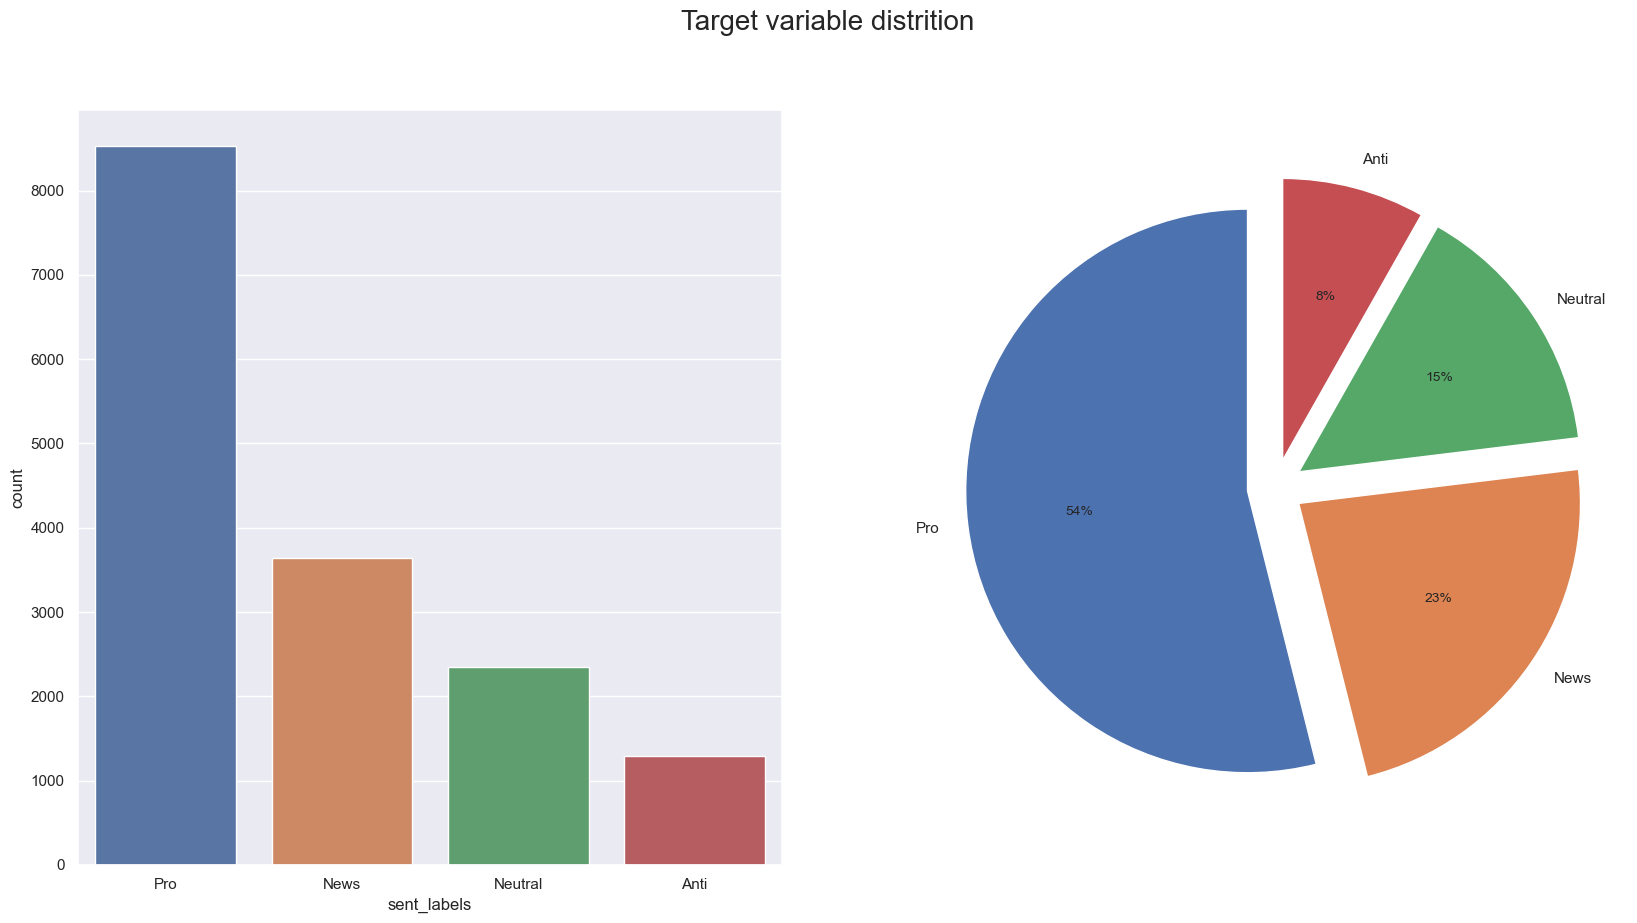

In [27]:
# Display target distribution

print("Percentage contribution:\n",train_eda.sent_labels.value_counts(normalize=True)*100)

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(train_eda['sent_labels'], ax=axes[0])

code_labels=['Pro', 'News', 'Neutral', 'Anti']
axes[1].pie(train_eda['sent_labels'].value_counts(),
            labels= code_labels,
            autopct='%1.0f%%',
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Target variable distrition', fontsize=20)
plt.show()

##### Quick observations:
* When we look at a histogram of our sentiments, we can see that the vast majority of them are Pro (the tweet supports the   belief of man-made climate change).
* There is a strong imbalance for sentiment classes
* Sentiment class '1' (Pro) dominates the chart with over 50% contribution, while class '-1' (Anti) lags behind with 8%.
* This tells us that the majority believes in man-made climate change 

## Investigate the feature variable

At this stage we want to understand the message and its contents much better, to draw fruitful insghts about our target variable. 

### Sentiment Analysis

Sentiment analysis is a technique that detects the underlying sentiment in a piece of text. It is the process of classifying text as either positive, negative, or neutral. The values range from 1 to -1; with positivity decreasing from 1 to -1, having a neutral sentiment at 0.

![Alt_text](https://miro.medium.com/max/687/1*FRd4BsrZ2VxKLbvVYJQC6w.png)


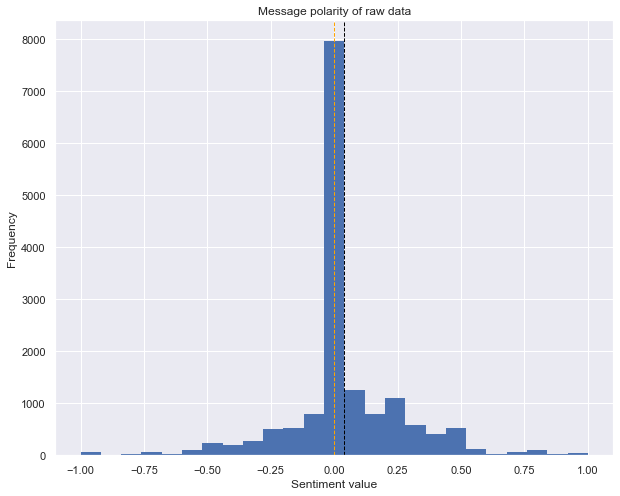

In [28]:
#Compare the sentiment analysis from raw data

from textblob import TextBlob
train_eda['polarity']=train_eda['message'].apply(lambda x:
                                             TextBlob(x).sentiment.polarity)

plt.figure(figsize=[10, 8])
plt.hist(train_eda['polarity'], bins=25, linewidth=0)
plt.gca().set(title='Message polarity of raw data',
              ylabel='Frequency', xlabel = 'Sentiment value')
plt.axvline(train_eda['polarity'].mean(), color='black',
            linestyle='dashed', linewidth=1)
plt.axvline(train_eda['polarity'].median(), color='orange',
            linestyle='dashed', linewidth=1)

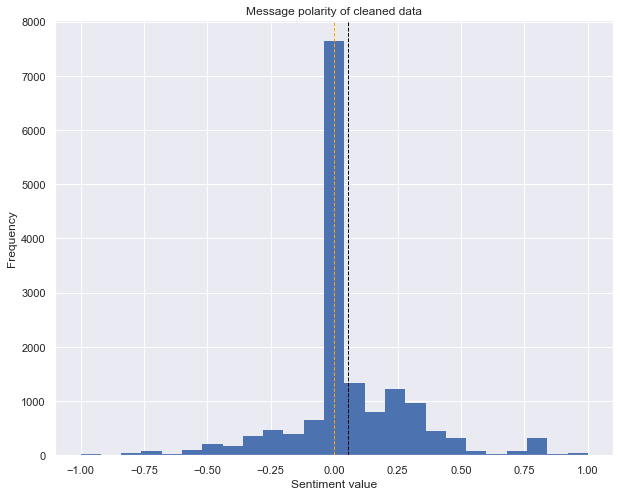

In [29]:
#Compare the sentiment analysis from cleaned data

# Convert the cleaned message from list to string
train_eda['message'] = train['message'].str.join(' ')

train['polarity']=train_eda['message'].apply(lambda x:
                                             TextBlob(x).sentiment.polarity)

plt.figure(figsize=[10, 8])
plt.hist(train['polarity'], bins=25, linewidth=0)
plt.gca().set(title='Message polarity of cleaned data',
              ylabel='Frequency', xlabel = 'Sentiment value')
plt.axvline(train['polarity'].mean(), color='black',
            linestyle='dashed', linewidth=1)
plt.axvline(train['polarity'].median(), color='orange',
            linestyle='dashed', linewidth=1)

###### Observation 
- Positively skewed sentiments, mean is greater than median.
- Majority of the tweets are around neutral sentiment
- Cleaned data has a greater mean than raw data; however, the central tendency show a similar trend for both. 
- This is an assurance that we didn't dilute the behaviour our data from cleaning it.

### Infiltrate text analysis
From here, we want to dig deeper into our text and investigate each word individually and its frequency of use. An in-depth examination of the tweets themselves is conducted. The most popular words are observed, and the most common words are classified according to their sentiment. These observations are made in order to gain a better understanding of the opinions expressed in tweets. 

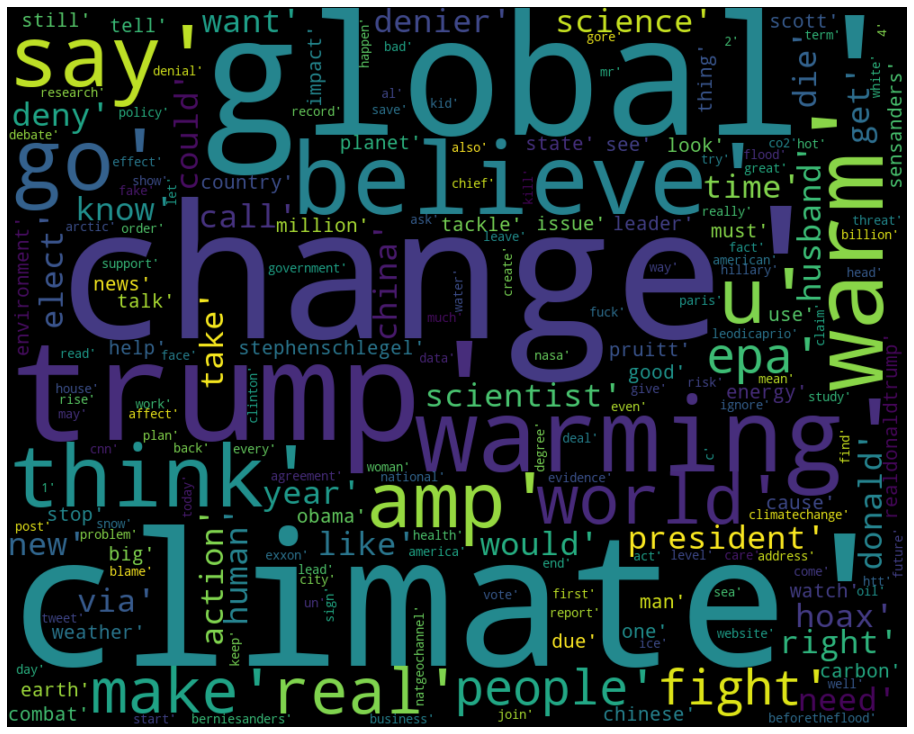

In [30]:
# WordCloud for cleaned data

from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

words = train['message']
allwords = []
for wordlist in words:
    allwords += wordlist
    
mostcommon = FreqDist(allwords).most_common(10000)
wordcloud = WordCloud(width=1000, height=800, background_color=
                      'black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

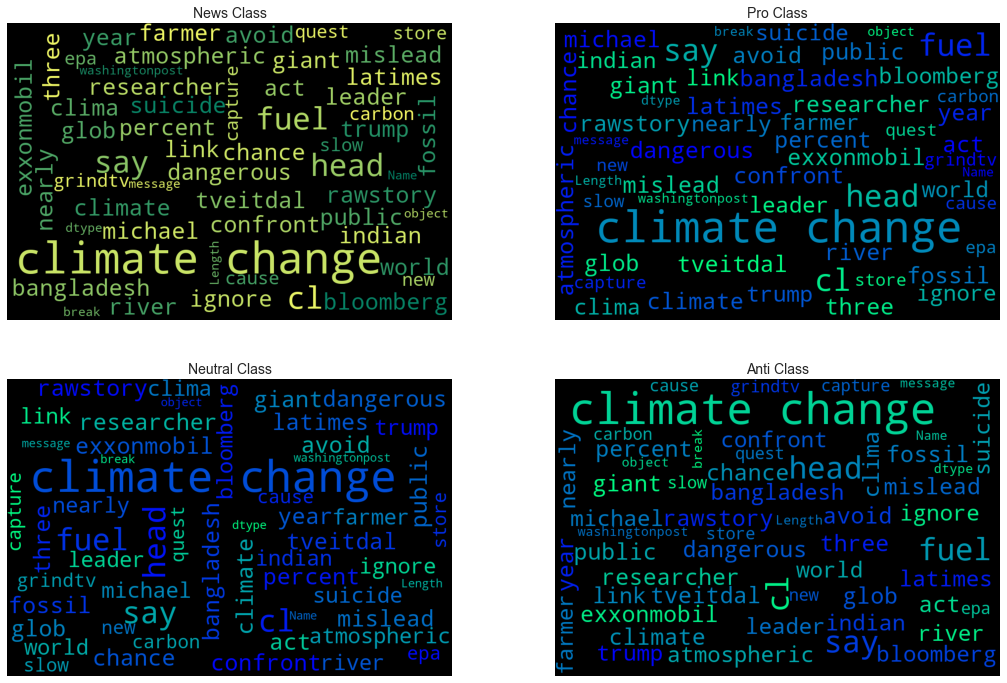

In [31]:
# Convert list to strings for each sentiment class
news = train['message'][train_eda['sentiment']==2].str.join(' ')
neutral = train['message'][train_eda['sentiment']==2].str.join(' ')
pro = train['message'][train_eda['sentiment']==2].str.join(' ')
anti = train['message'][train_eda['sentiment']==2].str.join(' ')

#Visualize each sentiment class

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

news_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='summer').generate(str(news))
axis[0, 0].imshow(news_wordcloud)
axis[0, 0].set_title('News Class',fontsize=14)
axis[0, 0].axis("off") 

neutral_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(neutral))
axis[1, 0].imshow(neutral_wordcloud)
axis[1, 0].set_title('Neutral Class',fontsize=14)
axis[1, 0].axis("off") 

pro_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(pro))
axis[0, 1].imshow(pro_wordcloud)
axis[0, 1].set_title('Pro Class',fontsize=14)
axis[0, 1].axis("off") 

anti_wordcloud = WordCloud(width=900, height=600, background_color='black', colormap='winter', min_font_size=10).generate(str(anti))
axis[1, 1].imshow(anti_wordcloud)
axis[1, 1].set_title('Anti Class',fontsize=14)
axis[1, 1].axis("off") 

plt.show()

### Frequency of most common words

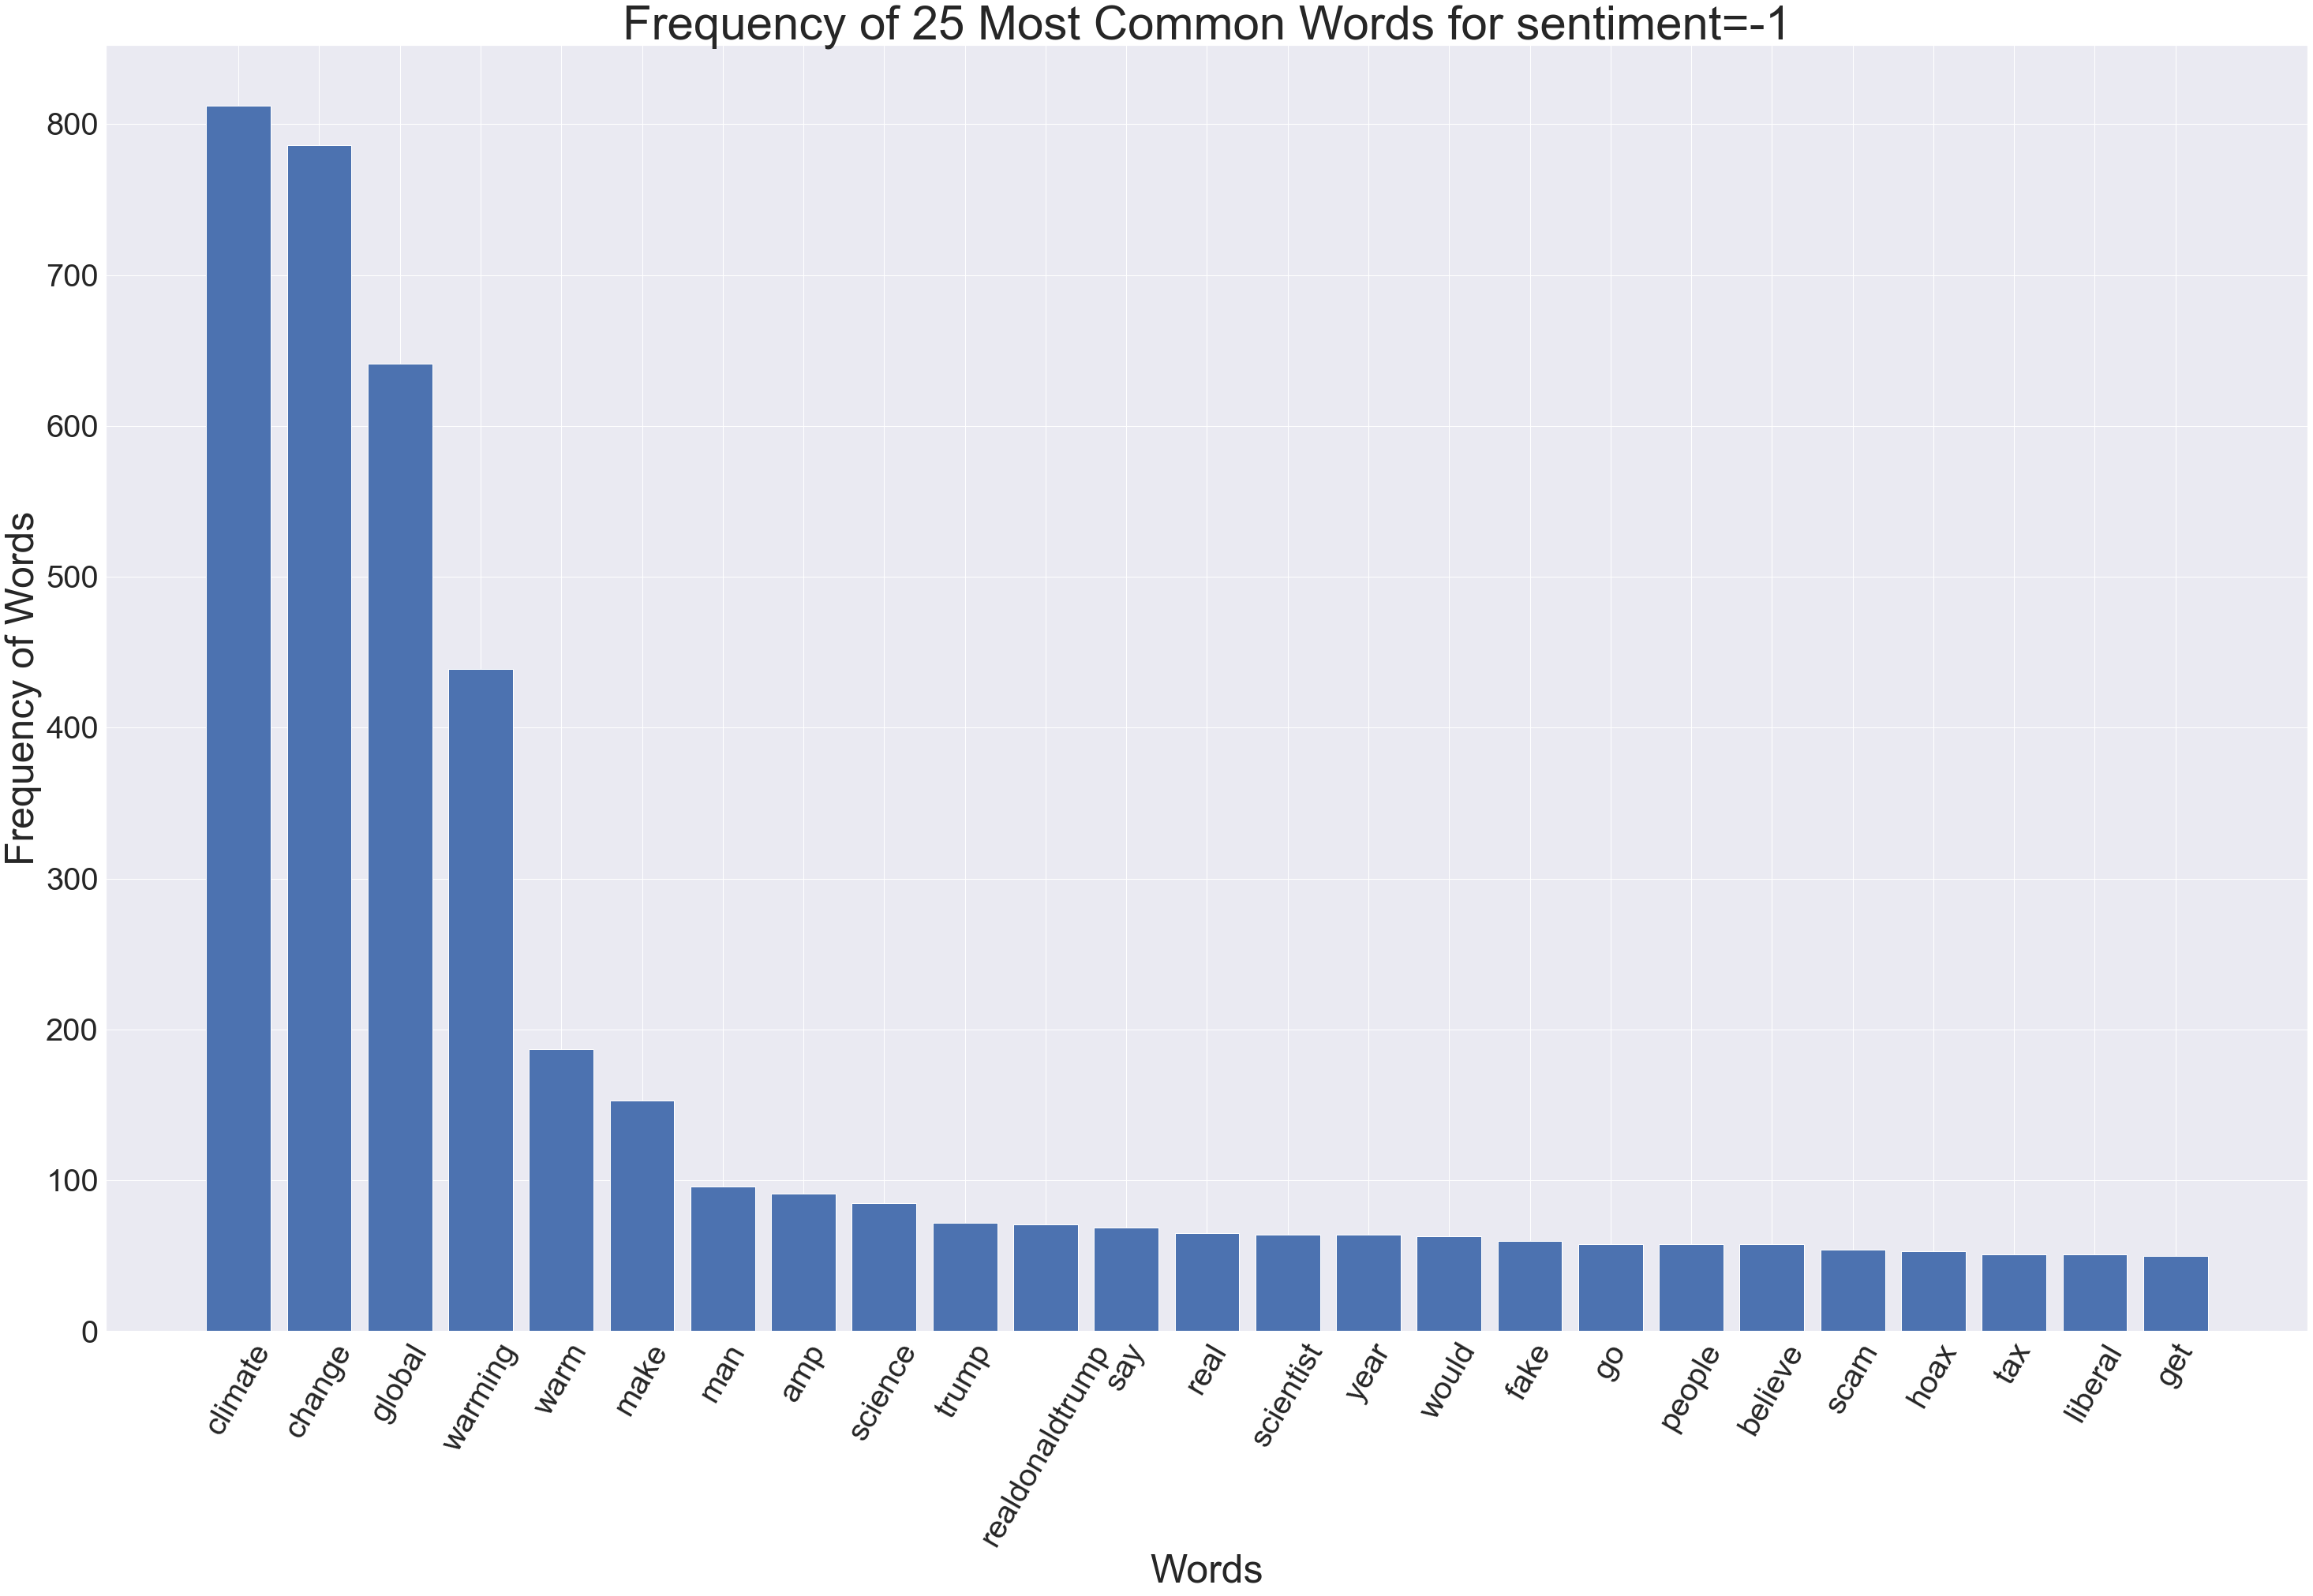

In [32]:
#convert the list into a string
train['freq'] = [' '.join(map(str,l)) for l in train['message']]
group_by = train.groupby('sentiment')['freq'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for sentiment=-1', fontsize=60)
plt.show()

The most prevalent terms associated with sentiments = -1 appeared to be "fake," "scam," and "hoax." As a result, it is clear that the prevailing mood is negative. This is to be anticipated from tweets that deny man-made climate change.

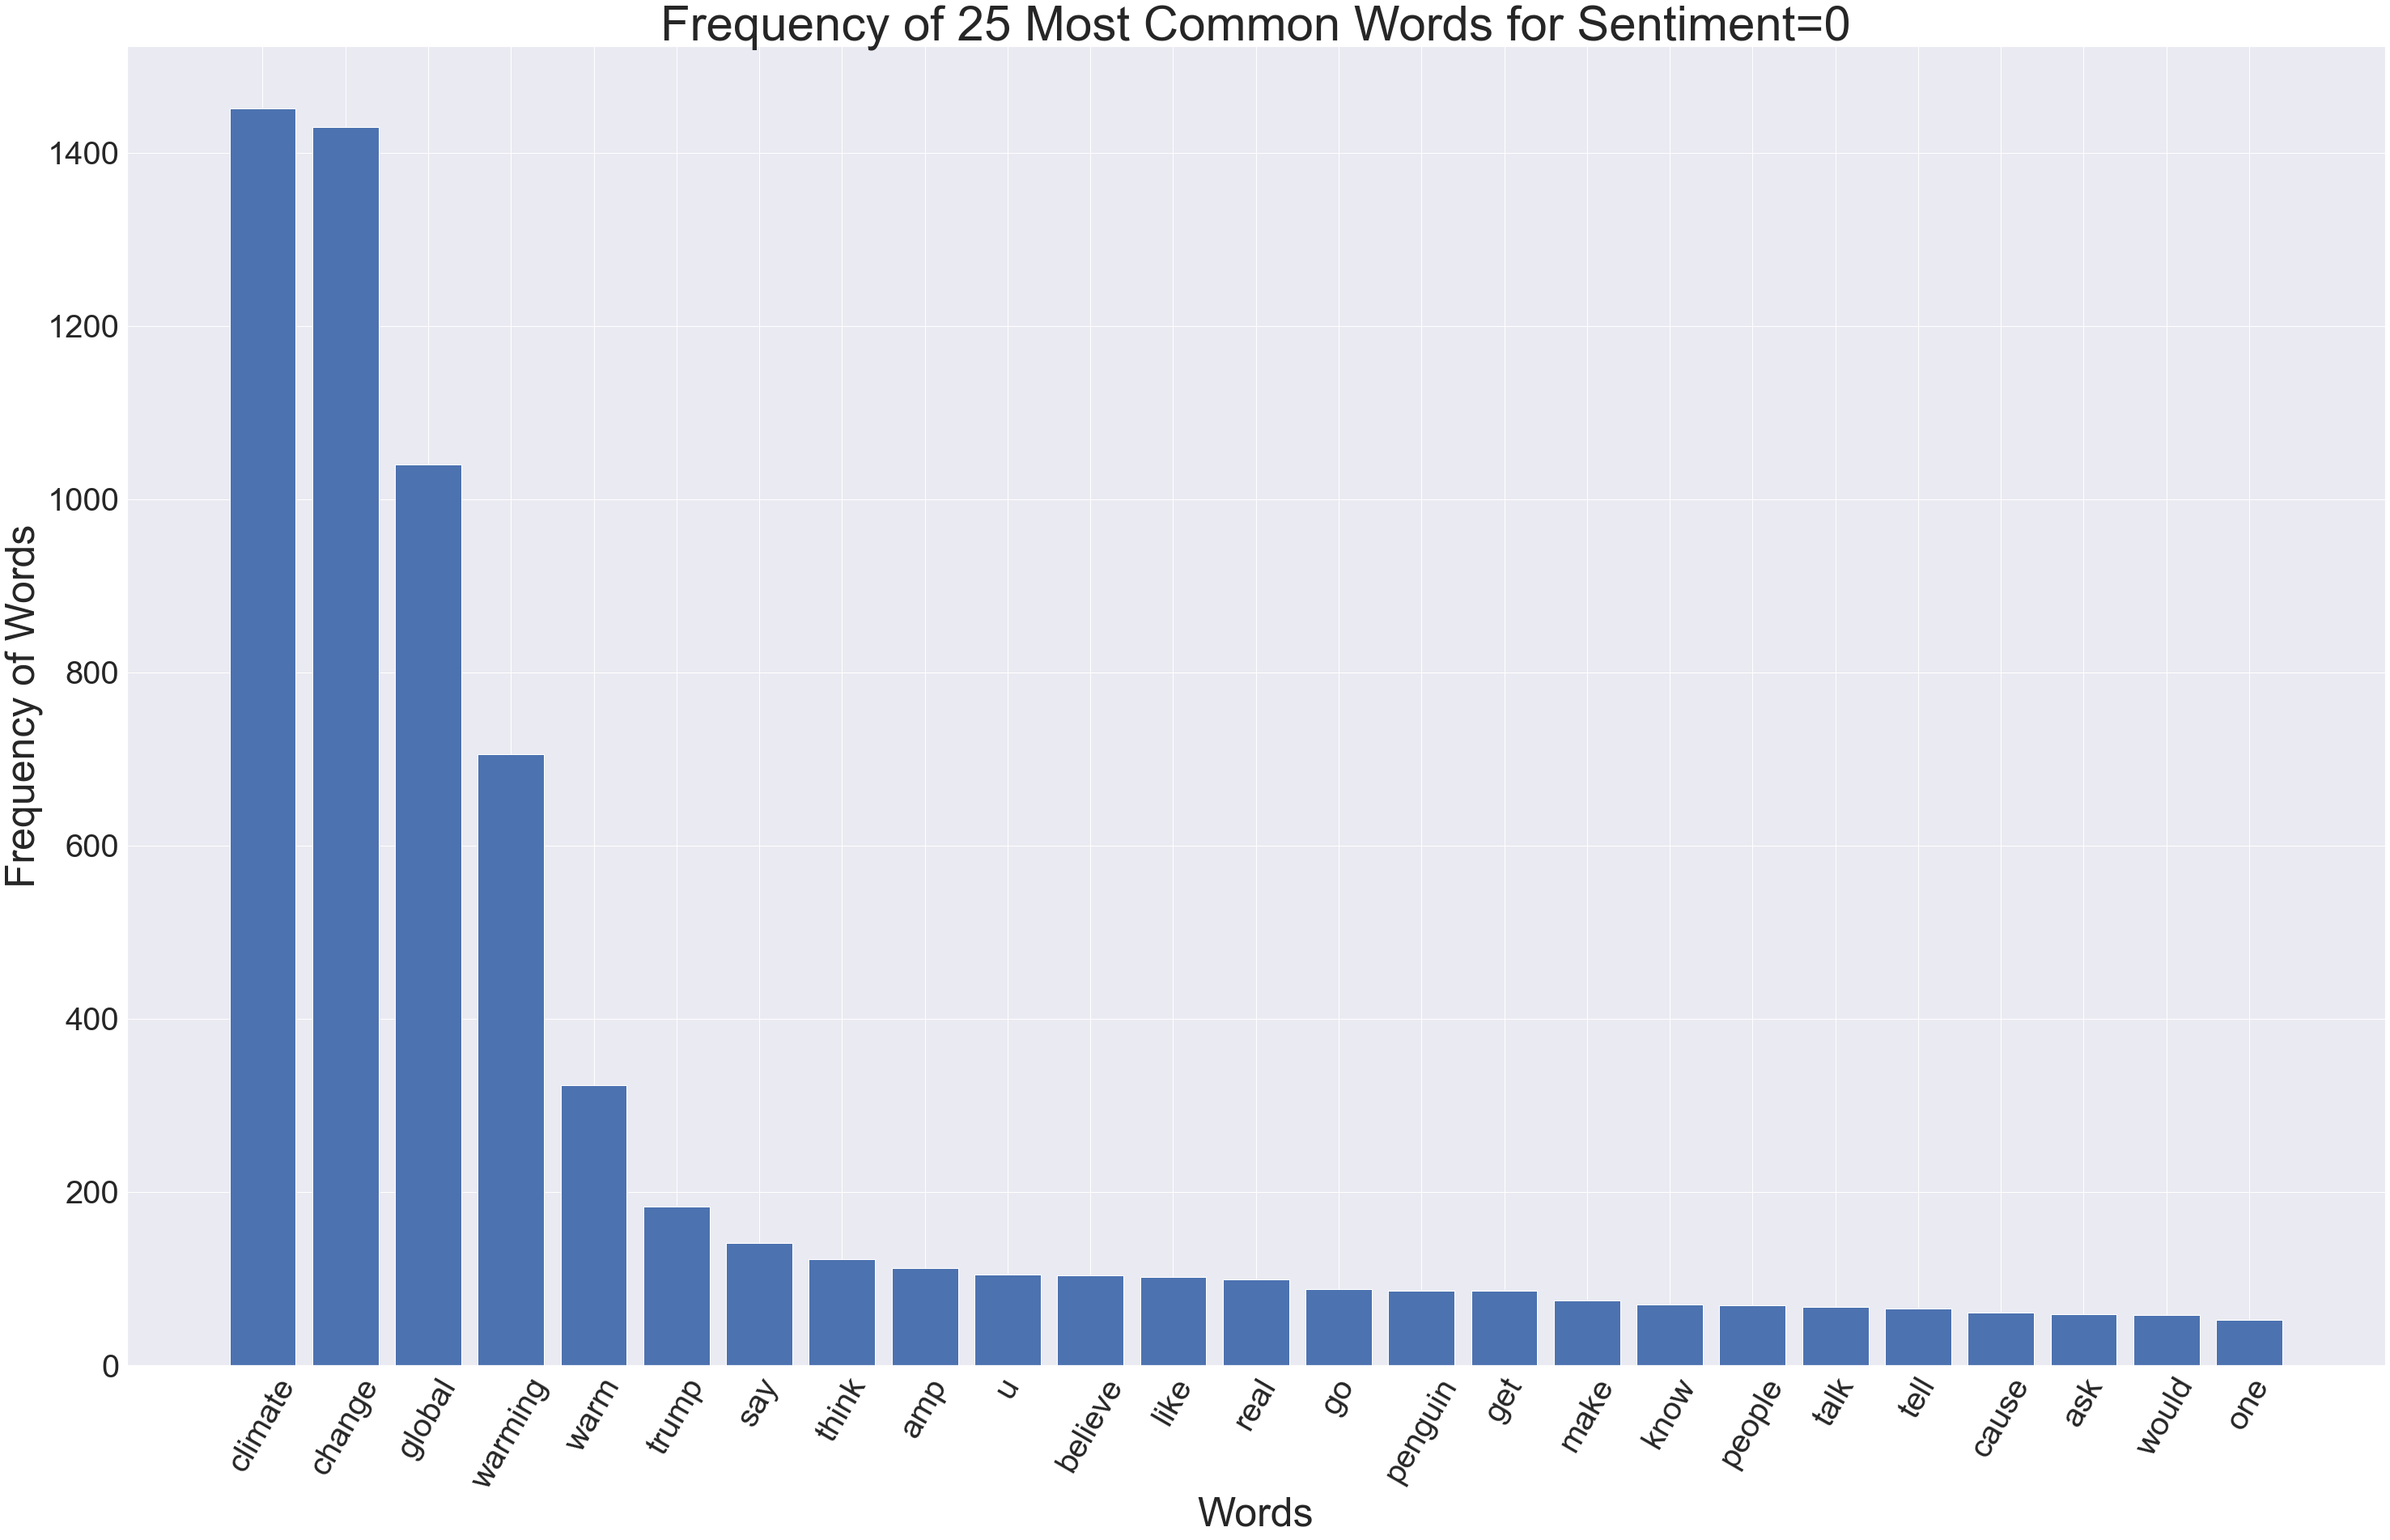

In [33]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Sentiment=0', fontsize=60)
plt.show()

The tweets do not explicitly state whether they are for or against climate change, as one might expect given that they do not support or reject the belief in man-made climate change.

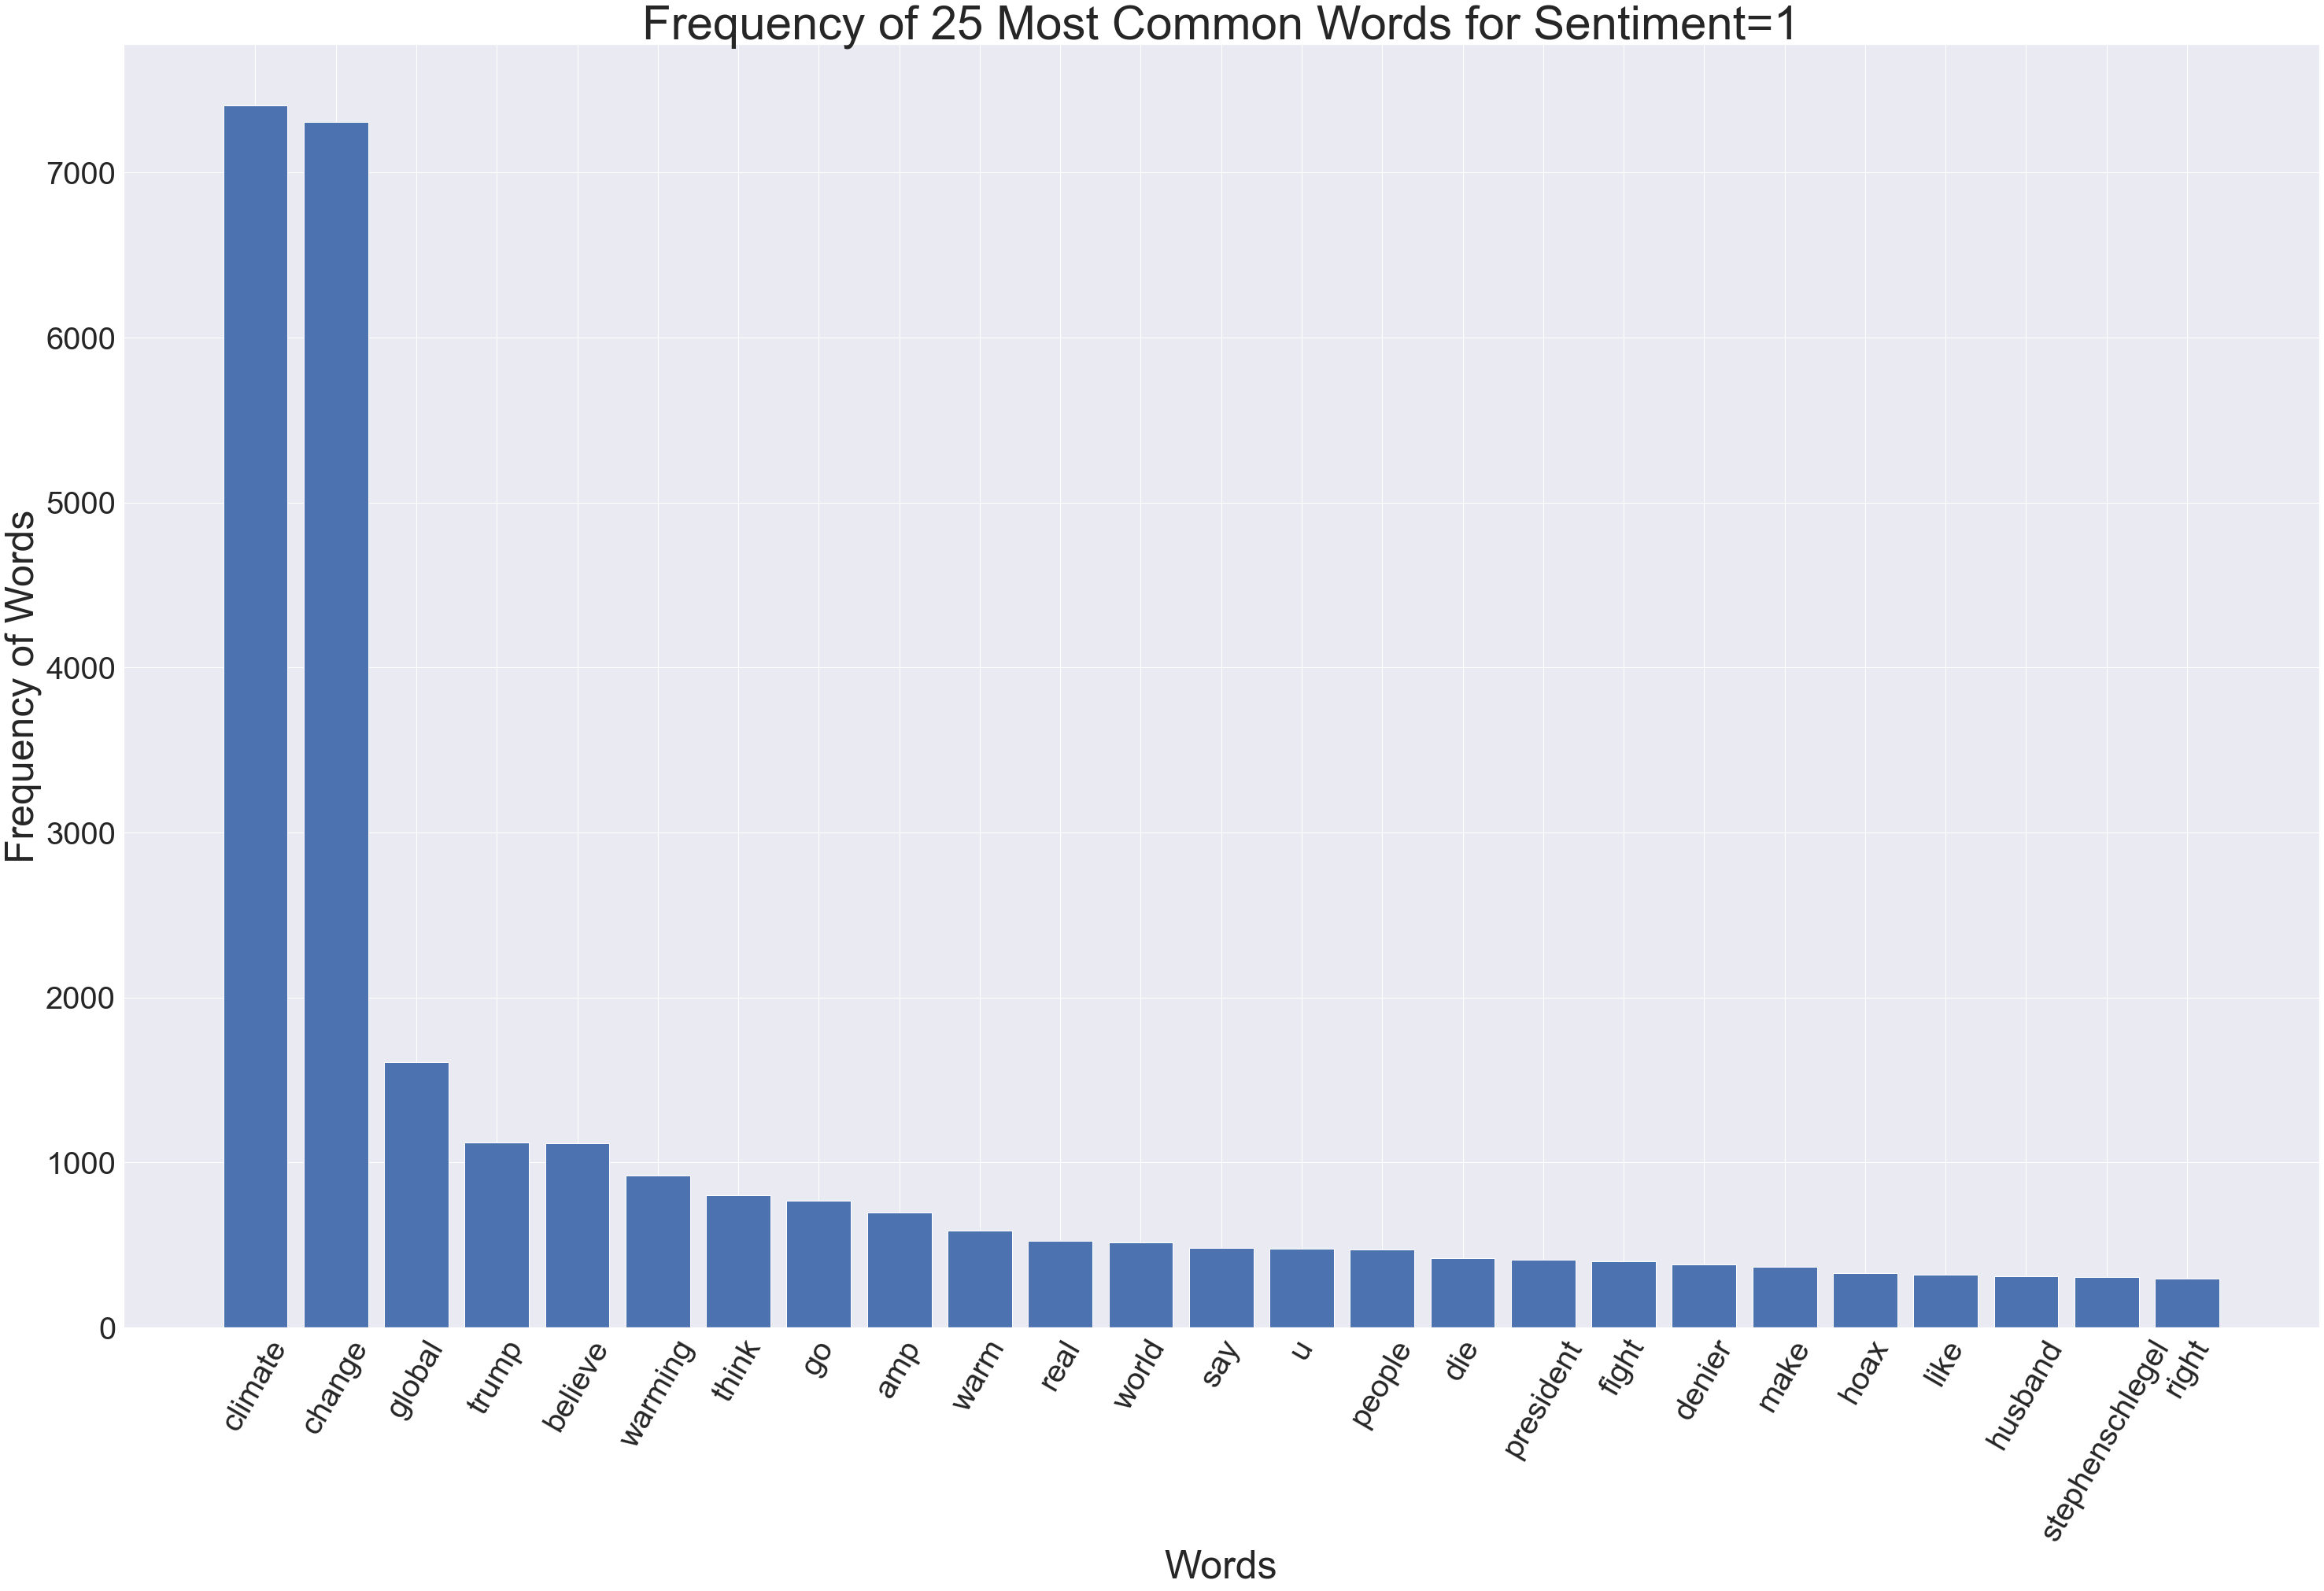

In [34]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Sentiment=1', fontsize=60)
plt.show()

It's difficult to derive accurate insights from the "Pro" sentiment because the words don't really provide context, but words like "real," "fight," "denier," and "make" can be extrapolated to indicate that the general context of the tweets is positive, with the tweets believing climate change is real, man-made, and that a fight should be waged to overcome climate change.

### Extract the hastags

In [35]:
# Get hashtags from raw data

train_eda = pd.read_csv('train.csv')
train_eda['no_stopwords'] = train_eda['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

hashtag = [item for item in train_eda['no_stopwords'].str.split() if item[0].startswith('#')]
hashtag = sum(hashtag, [])
count = nltk.FreqDist(hashtag)  
hashtag = pd.DataFrame({'hashtags': list(count.keys()),
                       'count': list(count.values())})
hashtag = hashtag.nlargest(20, columns="count")

hashtag.head()

,hashtags,count
7,climate,143
8,change,120
17,global,40
18,warming,21
49,-,21


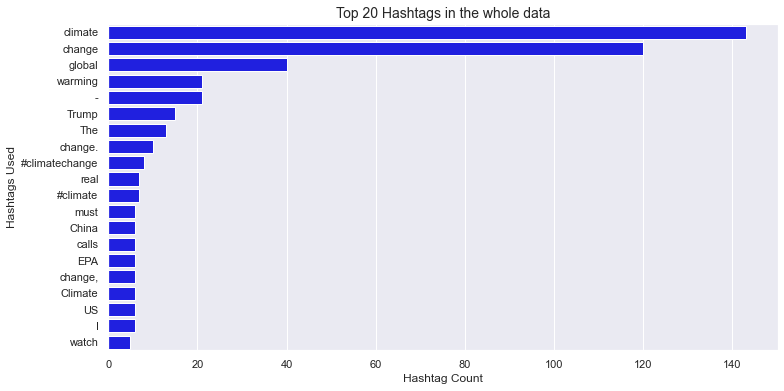

In [36]:
#Visualize the hastag count

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=hashtag, y ='hashtags', x ='count', orient='h', color = 'blue')
plt.title('Top 20 Hashtags in the whole data',fontsize=14)
plt.xlabel('Hashtag Count')
plt.ylabel('Hashtags Used')
plt.show()

### Named Entity Recognition
- Identify the names of people and organizations that are most included in each sentiment class.

In [37]:
train_eda.head()

,sentiment,message,tweetid,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's like lack evidence anthropogenic global w...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT @RawStory: Researchers say three years act ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 pivotal year war c...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT @SoyNovioDeTodas: It's 2016, racist, sexist..."


In [38]:
train['sent_labels']  = train['sentiment'].map({-1: 'Anti',0:'Neutral', 1:'Pro', 2:'News'})
train.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos,polarity,freq,sent_labels
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi...",0.255556,polyscimajor epa chief think carbon dioxide ma...,Pro
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop...",0.000000,like lack evidence anthropogenic global warming,Pro
2,2,"[rawstory, researcher, say, three, year, act, ...",698562,"[(rawstory, NN), (researchers, NNS), (say, VBP...","[(rawstory, n), (researchers, n), (say, v), (t...",-0.300000,rawstory researcher say three year act climate...,News
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi...",0.500000,todayinmaker wire 2016 pivotal year war climat...,Pro
4,1,"[soynoviodetodas, 2016, racist, sexist, climat...",466954,"[(soynoviodetodas, JJ), (2016, CD), (racist, N...","[(soynoviodetodas, a), (2016, n), (racist, n),...",0.000000,soynoviodetodas 2016 racist sexist climate cha...,Pro


# Splitting data into train and validation sets

Separating data into training and validation sets is an important part of evaluating our models. 
In our case we will randomly split the train data into 70% train and 30% validation. 
After our model is trained with the train data we then use it to make predictions for the target using the validation set,Because the data in the validation set already contains known values for the target variable this will make it easy  for us to asses our model's accuracy.

In [39]:
X = train_data['message']
y = train_data['sentiment']
X_test = test_data['message']

In [40]:
# Splitting the data into 70% train and 30% validation set
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

<a id='classifiers'></a>
## Building classification  pipelines


Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. below pipeline is used for the following classifiers:

#### Decision Tree Classifier

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are extremely intuitive ways to classify objects or predict continuous values: you simply ask a series of questions designed to zero-in on the classification/prediction.For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

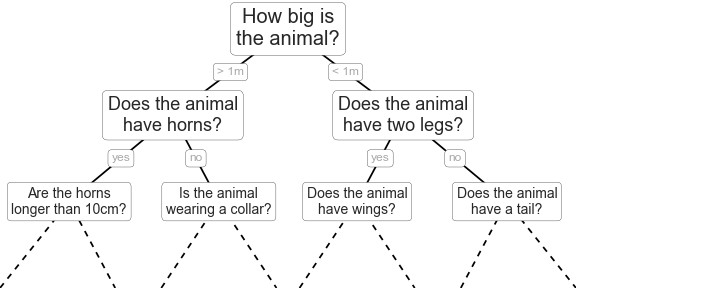

#### Random Forest Classifier

A random forest is a powerful non-parametric algorithm that is an example of an ensemble method built on decision trees, meaning that it relies on aggregating the results of an ensemble of decision trees. The ensemble of trees are randomized and the output is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

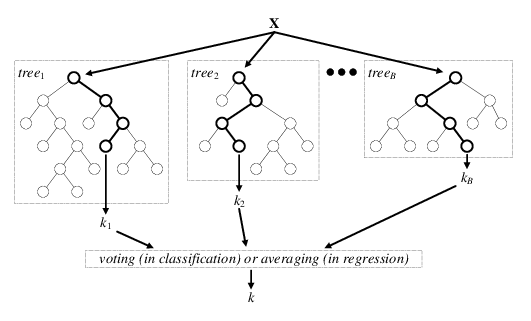

####  Linear Support Vector Classification

The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is.

#### Light Gradient Boosting Machine Classifier

Is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.

#### Logistic Regression

Makes use of a common S-shaped curve known as the logistic function. This curve is commonly known as a sigmoid. It solves the problem for the following reasons:

- It squeezes the range of output values to exist only between 0 and 1.
- It has a point of inflection, which can be used to separate the feature space into two distinct areas (one for each class).
- It has shallow gradients at both its top and bottom, which can be mapped to zeroes or ones respectively with little ambiguity.

#### stochastic gradient descent Classifier

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

#### Support Vector Machine

The basic idea of the SVM is to separate points using a  (p−1)  dimensional hyperplane. This means that the SVM will construct a decision boundary such that points on the left are assigned a label of  A  and points on the right are assigned a label of  B. When finding this separating hyperplane we wish to maximise the distance of the nearest points to the hyperplane. The technical term for this is maximum separating hyperplane. The data points which dictate where the separating hyperplane goes are called support vectors. You can see a diagram of the margin, hyperplane and support vectors below:

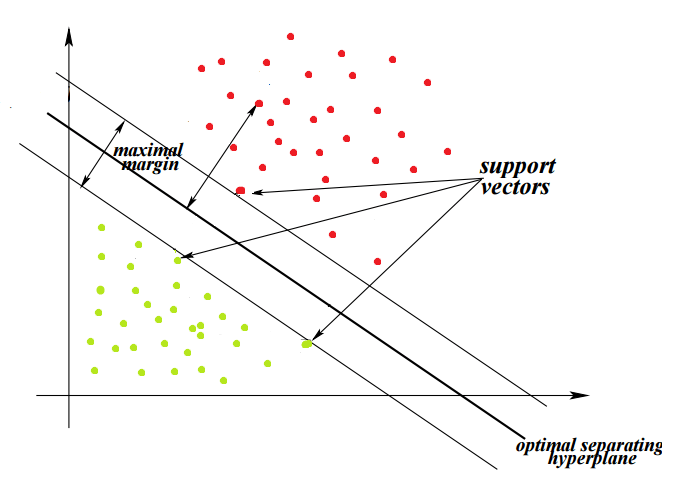

In [41]:
# DecisionTreeClassifier Pipeline
tree = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])


# RandomForestClassifier Pipeline
rfc = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])


# LinearSVC Pipeline
Lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
 
# LGBMClassifier Pipeline
lgbm = Pipeline([('tfidf', TfidfVectorizer()), ('lgbm', LGBMClassifier())])

# Logistic Regression pipeline
logreg = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression()),])


# SGD Classifier pipeline
SGD = Pipeline([('tfidf', TfidfVectorizer()), ('SGD', SGDClassifier())])

# Support Vector Classifier Pipeline
svc = Pipeline([('tfidf', TfidfVectorizer()), ('SVC', SVC())])

<a id='raw_tweets'></a>
## Training models
Each model is trained using it's custom pipeline which will take raw text data turn it into numeric data and initial the classifier with default parameters

In [42]:
# training the decision tree pipeline
tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
              

In [43]:
# training the RandomForest pipleline
rfc.fit(X_train, y_train)

COMET ERROR: Failed to extract parameters from estimator


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [44]:
# training the LinearSVC pipeline
Lsvc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('scv',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [45]:
# training the LGBMClassifier Pipleine
lgbm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
       

In [46]:
# training the logistic regression pipeline
logreg.fit(X_train, y_train)

C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sc

In [47]:
# training the SGD Classifier
SGD.fit(X_train, y_train)

# training the support vector classifier
svc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVC',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', deg

<a id='model_eval'></a>
# Modelling and Evaluation

<a id='model_eval'></a>
## Model evalution

To evaluate the base models we first start with making predictions for the validation set

In [48]:
# Making validations set predicions

tree_prediction = tree.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction = rfc.predict(X_val) # RandomForestClassifier predictions
Lsvc_prediction = Lsvc.predict(X_val) # LinearSVClassifier Predictions
lgbm_prediction = lgbm.predict(X_val) # LGBMClassifier Model predictions
logreg_prediction = logreg.predict(X_val) # Logistic regression predictions
SGD_prediction = SGD.predict(X_val) # SGD Classifier predictions
SVC_prediction = svc.predict(X_val) # Support vector machine predictions

### Evalution of DecisionTreeClassifier

In [49]:
print(confusion_matrix(y_val, tree_prediction))

[[ 100   77  159   53]
 [  52  271  333   50]
 [  89  287 1843  340]
 [  22   77  340  653]]


### Key Observations

In [50]:
from scikitplot.metrics import plot_roc, plot_confusion_matrix


Decision Tree
               precision    recall  f1-score   support

          -1       0.38      0.26      0.31       389
           0       0.38      0.38      0.38       706
           1       0.69      0.72      0.70      2559
           2       0.60      0.60      0.60      1092

    accuracy                           0.60      4746
   macro avg       0.51      0.49      0.50      4746
weighted avg       0.60      0.60      0.60      4746



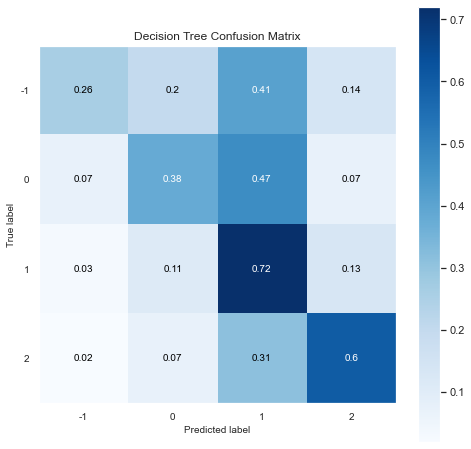

In [51]:
print('\nDecision Tree\n', classification_report(y_val, tree_prediction))
plot_confusion_matrix(y_val, tree_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

### Key Observations
A Classification report is used to measure the quality of predictions from a classification algorithm.

+ We can see a precision of 69% for pro climate which is higher,followed by news,neutral and anti climate change.
+ The precision for anti climate change and neutral are lower as compared to the models that we have tried. 

+ The recall values for the pro climate class of 72% is the highest.

+ Neutral in recall is as low as 4%.



The confusion matrix heatmap shows the recall score for each sentiment class.


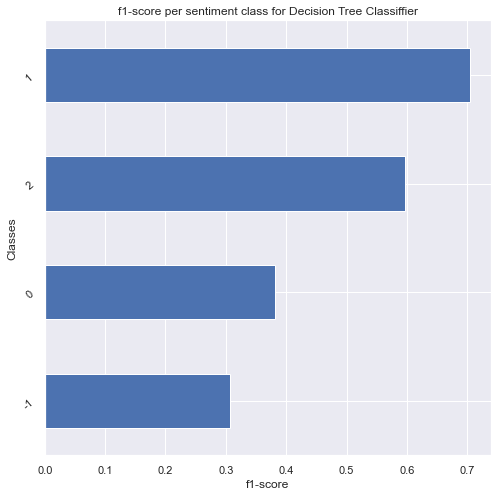

In [52]:
# # Visual represetation of of the f1 score for each class
report_tree = classification_report(y_val, tree_prediction, output_dict=True)
df_tree = pd.DataFrame(report_tree).transpose()
df_tree.drop(['accuracy'], inplace = True)
df_tree.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tree.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for Decision Tree Classiffier')
plt.show()

### Key Observations
The above bar graph shows the f1 score for each sentiment class using the Decision Tree classifier
- We see that the decision tree model did a very good job at classifiying `Pro climate change` tweets, followed by `News` and `Neutral` respectively.
- The Decision Tree classifier did a poor job at classifiying `Anti climate Change` tweets with an f1 score that is below 0.3.
- Poor classification of `Anti climate change` tweets is expected given the imbalance in our train data where we see that `Anti climate change` tweets only account for 8% of all tweets in the train dataset.

In [53]:
# Print the overall accuracy
decison_tree_acc = round(accuracy_score(y_val, tree_prediction),4)
print(f'\nOverall Accuracy score for Decision Tree : {decison_tree_acc}')
decision_tree_f1 = round(f1_score(y_val, tree_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score Decision Tree {decision_tree_f1}' )



Overall Accuracy score for Decision Tree : 0.6041

Weighted avg f1 score Decision Tree 0.5991


### Evalution of RandomForestClassifier

In [54]:
print('\nRandomForestClassifier\n', confusion_matrix(y_val, rfc_prediction))



RandomForestClassifier
 [[  45   40  282   22]
 [   3  226  435   42]
 [   2   50 2333  174]
 [   2    5  326  759]]



RandomForestClassifier
               precision    recall  f1-score   support

          -1       0.87      0.12      0.20       389
           0       0.70      0.32      0.44       706
           1       0.69      0.91      0.79      2559
           2       0.76      0.70      0.73      1092

    accuracy                           0.71      4746
   macro avg       0.76      0.51      0.54      4746
weighted avg       0.72      0.71      0.67      4746



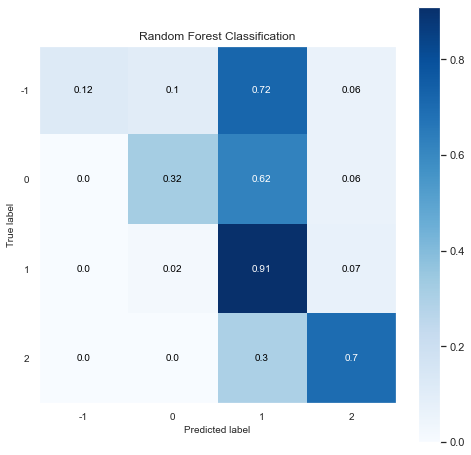

In [55]:
print('\nRandomForestClassifier\n', classification_report(y_val, rfc_prediction))
plot_confusion_matrix(y_val, rfc_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Random Forest Classification')
plt.show()

### Key Observations

We can see a precision of 72% for anti climate, 71% of neutral and news of 75% which is higher compared to `Decision Tree`.

The recall values for the pro climate class of 91% and news of 70% are the highest compared to `Decision Tree`.

Anti climate in recall dropped as compared to `Decision Tree`

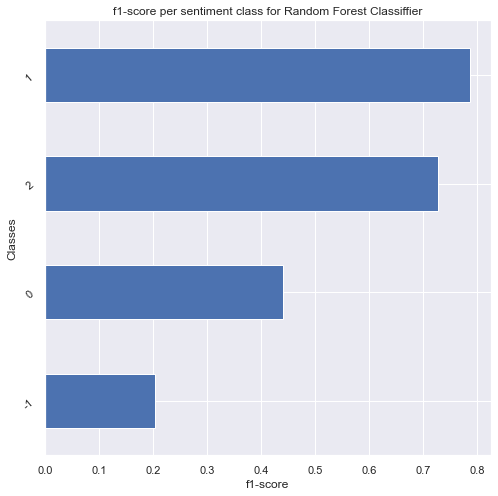

In [56]:
# # Visual represetation of of the f1 score for each class
report_rfc = classification_report(y_val, rfc_prediction, output_dict=True)
df_rfc = pd.DataFrame(report_rfc).transpose()
df_rfc.drop(['accuracy'], inplace = True)
df_rfc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_rfc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for Random Forest Classiffier')
plt.show()

### Key Observations
The above bar graph shows the f1 score for each sentiment class using the Random Forest classifier
- We see that the Random Forest model did a better job at classifiying `Pro climate change` tweeets and  `News`  comapred to the Decision tree model, with both the `Pro climate` and `News` sentimetents scoring over 0.7. and `Neutral` tweets following after that
- The Random Forest classifier did a poor job at classifiying `Anti climate Change` tweets with an f1 score lower than the one we got using the `Decision Tree` classifier.

In [57]:
random_forest_acc = round(accuracy_score(y_val, rfc_prediction),4)
print(f'\nOveral accuracy score for RandomForestClassifier :{random_forest_acc}')
random_forest_f1 = round(f1_score(y_val, rfc_prediction, average="weighted"),4)
print(f'\nWeighted f1 score for RandomForestClassifier : {random_forest_f1}')


Overal accuracy score for RandomForestClassifier :0.7086

Weighted f1 score for RandomForestClassifier : 0.6733


### Evaluation of LinearSVClassifier

In [58]:
print('\nLinearSVC Model\n', confusion_matrix(y_val, Lsvc_prediction))


LinearSVC Model
 [[ 158   53  148   30]
 [  31  265  340   70]
 [  35   95 2203  226]
 [   6   15  191  880]]



LinearSVC Model
               precision    recall  f1-score   support

          -1       0.69      0.41      0.51       389
           0       0.62      0.38      0.47       706
           1       0.76      0.86      0.81      2559
           2       0.73      0.81      0.77      1092

    accuracy                           0.74      4746
   macro avg       0.70      0.61      0.64      4746
weighted avg       0.73      0.74      0.72      4746



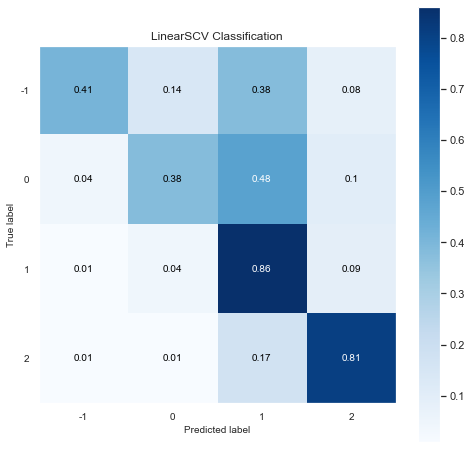

In [59]:
print('\nLinearSVC Model\n', classification_report(y_val, Lsvc_prediction))
plot_confusion_matrix(y_val, Lsvc_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('LinearSCV Classification')
plt.show()

### Key Observations

+ We can see a precision of 69% for anti climate which is higher compared to `Decision Tree` but it dropped compared to `Random Forest`.
+ Precision of 69% for pro climate which is higher compared to `Decision Tree` and `Random Forest`.

+ The recall value for the news class of 81% is the highest compared to `Decision Tree` and `Random Forest`
+ The recall value for the pro climate class  dropped compared to  `Random Forest`
+ Anti climate in recall increased as compared to `Random Forest` and `Decision Tree`

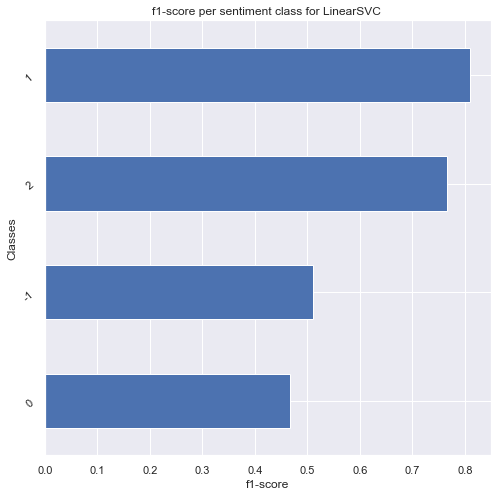

In [60]:
# # Visual represetation of of the f1 score for each class
report_svc = classification_report(y_val, Lsvc_prediction, output_dict=True)
df_svc = pd.DataFrame(report_svc).transpose()
df_svc.drop(['accuracy'], inplace = True)
df_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for LinearSVC ')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the LinearSVC
- We see that the LinearSVC model did a far better job at classifiying `Pro climate change` tweeets  compared to `Decision Tree` and `RandomForest` models  with the f1 score of label 1 sentiment class of over 0.8.
- The LinearSVC model also did a far better job at classifying `News` tweets comapred to both the Decision tree model and RandomForest model with the highest score level 2 sentiment class of over 0.75.
- We also see aa huge improvement in the classification of `Anti climate change` tweets with an f1 score just over 0.5, increasing from just below 0.3 that we saw with the `Decision Tree` classifier 
- There was a slight improvement in the classification of `neutral` tweets with the LinearSVC, which is by far overshadowed by the improvements we see in other sentiments classes

In [61]:
linearSVC_acc = round(accuracy_score(y_val, Lsvc_prediction),4)
print(f'\nOverall accuracy score for LinearSVC Model : {linearSVC_acc}')
linearSVC_f1 = round(f1_score(y_val, Lsvc_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for LinearSVC Model : {linearSVC_f1}')


Overall accuracy score for LinearSVC Model : 0.7387

Weighted avg f1 score for LinearSVC Model : 0.7242


### Evaluation of LGBMClassifier

In [62]:
print('\nLightGBM\n', confusion_matrix(y_val, lgbm_prediction))


LightGBM
 [[  77   59  223   30]
 [  11  278  372   45]
 [  20  110 2187  242]
 [   3   26  265  798]]



LightGBM
               precision    recall  f1-score   support

          -1       0.69      0.20      0.31       389
           0       0.59      0.39      0.47       706
           1       0.72      0.85      0.78      2559
           2       0.72      0.73      0.72      1092

    accuracy                           0.70      4746
   macro avg       0.68      0.54      0.57      4746
weighted avg       0.70      0.70      0.68      4746



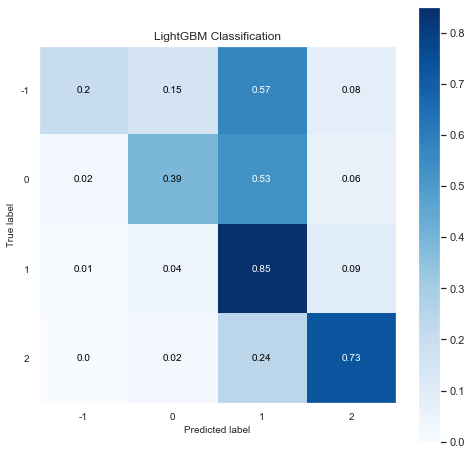

In [63]:
print('\nLightGBM\n', classification_report(y_val, lgbm_prediction))
plot_confusion_matrix(y_val, lgbm_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('LightGBM Classification')
plt.show()

 ### Key Observations

+ We can see a precision of 66% for anti climate and neutral dropped compared to `LinearSVC` and `Random Forest`. but increased compared to `Decision Tree`

+ The recall values for the pro climate class of 84% dropped compared to `LinearSVC` and `Random Forest` but it has increased compared to `Decision Tree`.
+ The neutral class in recall increased as compared to `Random Forest`, `LinearSVC` and `Decision Tree`

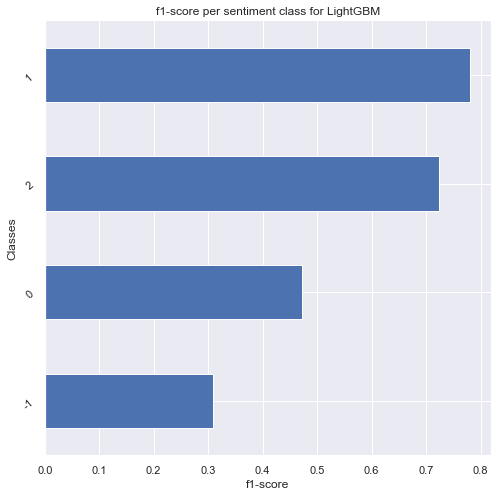

In [64]:
# # Visual represetation of of the f1 score for each class
report_lgbm = classification_report(y_val, lgbm_prediction, output_dict=True)
df_lgbm = pd.DataFrame(report_lgbm).transpose()
df_lgbm.drop(['accuracy'], inplace = True)
df_lgbm.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_lgbm.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for LightGBM')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the LightGBM
- Although the LightGBM model did a far better job at classifying `Pro climate tweets` and `News` compared to `Decision Tree` and `Random Forest` it is not as good as the `LinearSVC`
- We see a slight increase in the classification of `neutral` tweets compared to the classification of `LienarSVC`
- We see that the classification of `Anti climate change` tweets for `LightGBM` has decreased compared to `LinearSVC`, howver `LightGBM` still classifies the `Anti climate change` sentiment class better compared to the first two models we tried `Decision Tree` and `Random Forest` 

In [65]:
lGBM_acc = round(accuracy_score(y_val, lgbm_prediction),4)
print(f'\nOverall accuracy score for LightGBM :{lGBM_acc}')
lGBM_f1 = round(f1_score(y_val, lgbm_prediction, average="weighted"),4)
print(f'\nWeighted f1 score for LightGBM :{lGBM_f1}')


Overall accuracy score for LightGBM :0.7038

Weighted f1 score for LightGBM :0.6825


# Evaluation of  Logistic Regression 

In [66]:
# Report the confusion matrix
print('\nLogistic Regression\n', confusion_matrix(y_val, logreg_prediction))


Logistic Regression
 [[  91   39  230   29]
 [  13  207  411   75]
 [  10   47 2279  223]
 [   5    4  223  860]]



Logistic Regression
               precision    recall  f1-score   support

          -1       0.76      0.23      0.36       389
           0       0.70      0.29      0.41       706
           1       0.73      0.89      0.80      2559
           2       0.72      0.79      0.75      1092

    accuracy                           0.72      4746
   macro avg       0.73      0.55      0.58      4746
weighted avg       0.72      0.72      0.70      4746



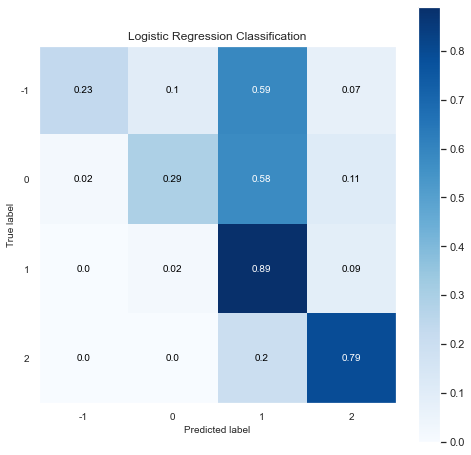

In [67]:
# Print a classification report

print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction))
plot_confusion_matrix(y_val, logreg_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Logistic Regression Classification')
plt.show()



 ### Key Observations

+ We can see a precision of 76% for anti climate which is higher compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest`.

+ The recall values for the pro climate class of 89% is the highest compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest`
+ Anti climate in recall is the same as `LGBMClassifier` and it has increased as compared to `Random Forest` and `Logistic Regression` but is has dropped as compared to `LinearSVC` and `Decision Tree`

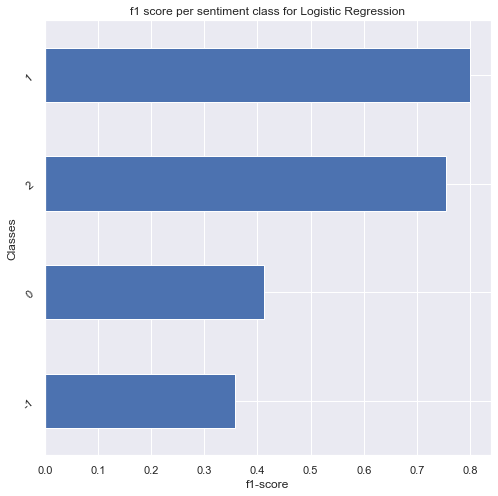

In [68]:
# # Visual represetation of of the f1 score for each class
report_logreg = classification_report(y_val, logreg_prediction, output_dict=True)
df_logreg = pd.DataFrame(report_logreg).transpose()
df_logreg.drop(['accuracy'], inplace = True)
df_logreg.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_logreg.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1 score per sentiment class for Logistic Regression')
plt.show()

In [69]:
# Print the overall accuracy
logistic_reg_acc = round(accuracy_score(y_val, logreg_prediction),4)
print('\nLogistic Regression accuracy Score\n', logistic_reg_acc)
logistic_reg_f1 = round(f1_score(y_val, logreg_prediction, average="weighted"),4)
print('\nLogistic Regression weighted f1 score\n', logistic_reg_f1)



Logistic Regression accuracy Score
 0.7242

Logistic Regression weighted f1 score
 0.6954


# Evaluation of SGD Classifier

In [70]:
# Confusion matrix for the random forest classifier
print('\nSGD Classifier\n', confusion_matrix(y_val, SGD_prediction))


SGD Classifier
 [[ 140   35  184   30]
 [  19  235  371   81]
 [  19   59 2252  229]
 [   7    4  211  870]]



SGD Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.76      0.36      0.49       389
           0       0.71      0.33      0.45       706
           1       0.75      0.88      0.81      2559
           2       0.72      0.80      0.76      1092

    accuracy                           0.74      4746
   macro avg       0.73      0.59      0.63      4746
weighted avg       0.73      0.74      0.72      4746



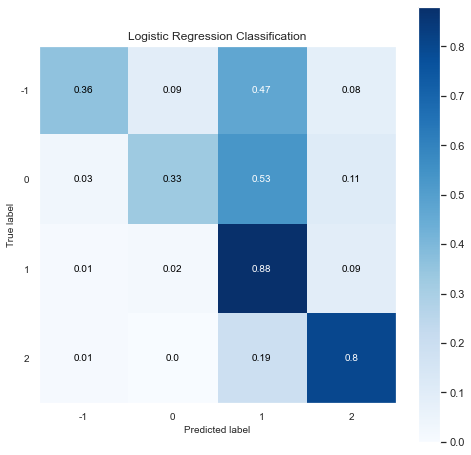

In [71]:
# The classification report 
print('\nSGD Classifier  Classification report :\n', classification_report(y_val, SGD_prediction))
plot_confusion_matrix(y_val, SGD_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Logistic Regression Classification')
plt.show()


### Key Observations

+ We can see a precision of anti and neutral are higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier` and `Logistic Regression`. it is not more than the anti climate of `Random Forest` but more than neutral.
+ The precision value for the news class dropped compared to the  `Decision Tree`

+ -The recall value for the pro climate class of 88% is the highest compared to `Decision Tree`, `LinearSVC` and `LGBMClassifier` it is not more than `Random Forest` and `Logistic Regression`.
+ Anti climate has increased in recall as compared to `Decision Tree`, `Random Forest`, `LGBMClassifier` and `Logistic Regression` but is has dropped as compared to `LinearSVC`
+ Neural has dropped in recall as compared to `Decision Tree`, `LinearSVC`and  `LGBMClassifier` but is has dropped as compared to `Random Forest` and `Logistic Regression`

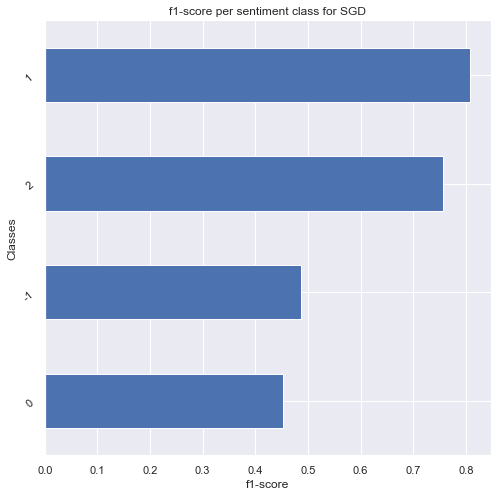

In [72]:
# # Visual represetation of of the f1 score for each class
report_sgd = classification_report(y_val, SGD_prediction, output_dict=True)
df_sgd = pd.DataFrame(report_sgd).transpose()
df_sgd.drop(['accuracy'], inplace = True)
df_sgd.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_sgd.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for SGD')
plt.show()

In [73]:
# Checking the accuracy score
sgd_acc = round(accuracy_score(y_val, SGD_prediction),4)
print('\nSGD Classifier accuracy Score :\n', sgd_acc)

# Checking the f1_score report for the decison tree model
sgd_f1 = round(f1_score(y_val, SGD_prediction, average="weighted"),4)
print('\nSGD weighted avg f1_score :\n', sgd_f1)


SGD Classifier accuracy Score :
 0.7368

SGD weighted avg f1_score :
 0.7166


# Support Vector Classfifier

In [74]:
# Confusion matrix for the random forest classifier
print('\nSupport Vector Classifier\n', confusion_matrix(y_val, SVC_prediction))


Support Vector Classifier
 [[  78   24  265   22]
 [   7  175  460   64]
 [   6   28 2318  207]
 [   3    1  229  859]]



Support Vector Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.83      0.20      0.32       389
           0       0.77      0.25      0.37       706
           1       0.71      0.91      0.80      2559
           2       0.75      0.79      0.77      1092

    accuracy                           0.72      4746
   macro avg       0.76      0.54      0.56      4746
weighted avg       0.74      0.72      0.69      4746



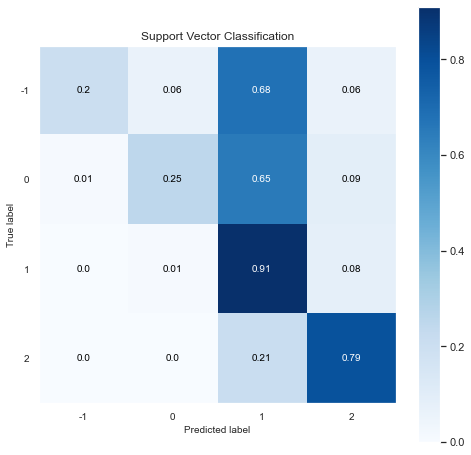

In [75]:
# The classification report 
print('\nSupport Vector Classifier  Classification report :\n', classification_report(y_val, SVC_prediction))
plot_confusion_matrix(y_val, SVC_prediction, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Support Vector Classification')
plt.show()


### Key Observations

+ We can see a precision of anti climate is higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier`. it is not more than the anti climate of `Random Forest`.


+ The recall value for the pro climate class of 91% is the same as `Random Forest` and higher compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier`.
+ Anti climate has dropped in recall as compared to `Decision Tree`, `LinearSVC`, `LGBMClassifier`, `Logistic Regression` and `SGD Classifier` but is has increased as compared to `Random Forest`

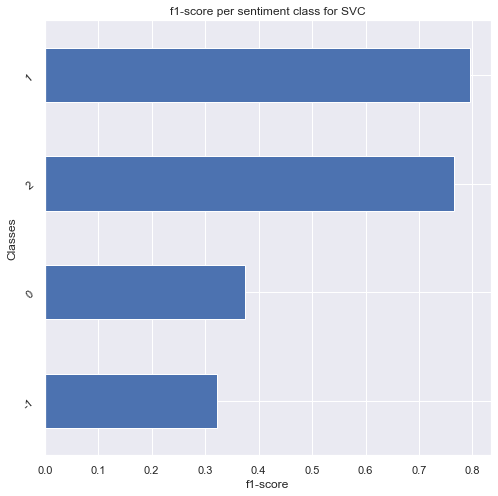

In [76]:
# # Visual represetation of of the f1 score for each class
report_svc = classification_report(y_val, SVC_prediction, output_dict=True)
df_SVC = pd.DataFrame(report_svc).transpose()
df_SVC.drop(['accuracy'], inplace = True)
df_SVC.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_SVC.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for SVC')
plt.show()

### Key observations
The above bar graph shows the f1 score for each sentiment class using the Support Vector Classifier(SVC)
- Much like the `LinearSVC` we see that the  the `SVC` does a really good job at classifying `Pro climate change` sentiment class with a score of 0.8, followed by the `News` sentiment class with an f1 score of over 0.75.
- Similar to most of the models we've tested thus far the  `Support Vector Classifer` struggled with classifying the `anti climate change` sentiment, scoring just over 0.3

In [77]:
# Checking the accuracy score
svc_acc = round(accuracy_score(y_val, SVC_prediction),4)
print(f'\nSupport Vector Classifier accuracy Score :{svc_acc}')
svc_f1 = round(f1_score(y_val, SVC_prediction, average="weighted"),4)
print(f'\nSupport Vector Classifier weighted avg f1_score :{svc_f1}')


Support Vector Classifier accuracy Score :0.7227

Support Vector Classifier weighted avg f1_score :0.6871


### Model Comparision

Model comparison by accuracy and macro f1_score

In [78]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC',
                                    'LGBM','Logistic Regression','Stochastic Gradient Descent','Support Vector Classifier'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,lGBM_acc,logistic_reg_acc, sgd_acc, svc_f1],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,lGBM_f1,logistic_reg_f1, sgd_f1, svc_f1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

,Classifiers,Accuracy,Weighted avg f1 Score
0,Decision Tree,0.6041,0.5991
6,Support Vector Classifier,0.6871,0.6871
3,LGBM,0.7038,0.6825
1,Random Forest,0.7086,0.6733
4,Logistic Regression,0.7242,0.6954
5,Stochastic Gradient Descent,0.7368,0.7166
2,LinearSVC,0.7387,0.7242


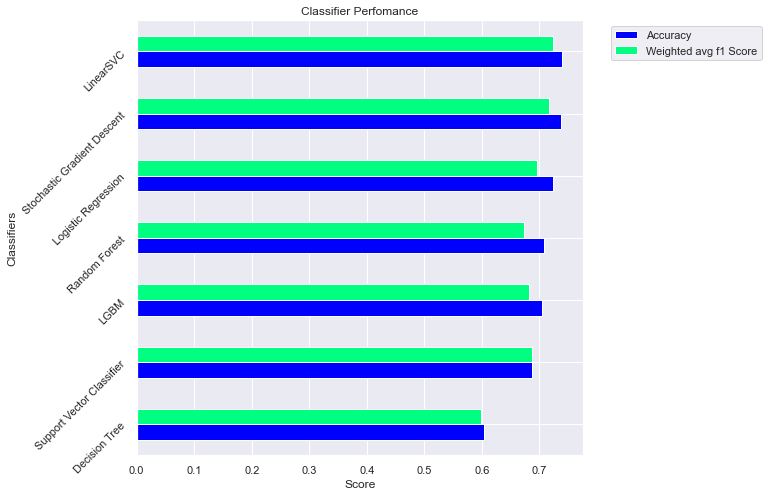

In [79]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='winter')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Key observations

From the above bar graph we see comparison of all the 7 models we've attempted thus far based on their `accuracy score` and associated `wighted f1 score`

- We see that our top 3 best performing models are `LinearSVC`,`Stochastic Gradient Descent` and `Logistic Regression` respectively, theres are the models will use in ensemble methods to try and improve our results
- The `Decision Tree` classifer is the worst  at classifying the tweets with the lowest accuracy and wighted f1 scores of 0.61 and 0.60 respectivey

**LinearSVC is the best performing model out of all 7 models that we've tried thus far with an accuracy score of 0.74 and a weighted f1 score of 0.72**

# Ensemble Methods

Ensemble learning in machine learning is the practice of combining multiple models to try and achieve higher overall model performance. In general, ensembles consist of multiple **heterogeneous or homogeneous** models trained on the same dataset. Each of these models is used to make predictions on the same input, then these predictions are aggregated across all models in some way (e.g. by taking the mean) to produce the final output.

<a id='ensemble'></a>
## Heterogeneous Ensembel Method
This type of ensemble consists of different types of models, so it can add pretty much any classification model we want, however in our case we're only going to add our top 3 best perfoming models which are, `LinearSVC, Stochastic Gradient Descent, Logistic Regression, `.

The Heterogeneous ensemble method we're going to look at is the `Voting classifier`


### Voting classifer 
Voting involves combining individual model outputs through a kind of "[majority rule](https://en.wikipedia.org/wiki/Majority_rule)" paradigm.
The diagram below shows how the `Voting Classifier` works
![ud382N9.png](https://iq.opengenus.org/content/images/2020/01/ud382N9.png)

In [80]:
# Define the models which we'll include in our ensemble. 
# We pass a list of tuples, which each have a string identifier for the
# model (arbitrary choice), along the actual instantiated sklearn model.  
models = [("LinearSVC",Lsvc),("SGD",SGD),("Logistric Regression",logreg)]

# Specify weights for weighted model averaging
model_weightings = np.array([0.1,0.3,0.6])

# building the voting classifier
Voting_classifier = VotingClassifier(estimators=models,weights=model_weightings)


In [81]:
# training the voting classifier
Voting_classifier.fit(X_train, y_train)

C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
COMET ERROR: Failed to extract parameters from estimator


VotingClassifier(estimators=[('LinearSVC',
                              Pipeline(memory=None,
                                       steps=[('tfidf',
                                               TfidfVectorizer(analyzer='word',
                                                               binary=False,
                                                               decode_error='strict',
                                                               dtype=<class 'numpy.float64'>,
                                                               encoding='utf-8',
                                                               input='content',
                                                               lowercase=True,
                                                               max_df=1.0,
                                                               max_features=None,
                                                               min_df=1,
                                          

In [82]:
voting_prediction = Voting_classifier.predict(X_val) # Voting Classifier predictions

In [83]:
# The classification report 
print('\nVoting Classifier  Classification report :\n', classification_report(y_val, voting_prediction))


Voting Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.76      0.23      0.36       389
           0       0.70      0.29      0.41       706
           1       0.73      0.89      0.80      2559
           2       0.72      0.79      0.75      1092

    accuracy                           0.72      4746
   macro avg       0.73      0.55      0.58      4746
weighted avg       0.72      0.72      0.70      4746



In [84]:
# Checking the accuracy score
voting_acc = round(accuracy_score(y_val, voting_prediction),4)
print(f'\nOverall accuracy for the Voting Classifier :{voting_acc}')
voting_f1 = round(f1_score(y_val, voting_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for the Voting Classifier :{voting_f1}')


Overall accuracy for the Voting Classifier :0.7242

Weighted avg f1 score for the Voting Classifier :0.6954


## Homogeneous Ensembles

These consist of the same type of model. As such, a common way to promote diversity in model performance in these cases is to control the number of predictors or portion of data supplied to each model in the ensemble. Much like what happens in a random forest.

Some the most common methods for combining models in this way include **bagging** and **boosting**.

### Bagging (AKA Bootstrap Aggregating)

Bagging involves training the models of the ensemble on different subsets of the training data. Particularly on subsets which are **sampled with replacement** from the training data. As such, the resulting 'bag' of models are together more stable due to decreased variance error. 

The predictions are made by aggregating the predictions of all the models in the bag.
![1*JksRZ1E72Rsx2s8lQbNR1w.jpeg](https://miro.medium.com/max/875/1*JksRZ1E72Rsx2s8lQbNR1w.jpeg)

In [85]:
bag_class= Pipeline([('tfidf', TfidfVectorizer()),
                     ('bag', BaggingClassifier(base_estimator = LinearSVC())),])
 


In [86]:
bag_class.fit(X_train, y_train)

COMET ERROR: Failed to extract parameters from estimator


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                            class_weight=None,
                                                            dual=True,
                                                            fit_intercept=True,
                                                            intercept_sc

In [87]:
bag_prediction = bag_class.predict(X_val) # Bagging Classifier predictions

In [88]:
# The classification report 
print('\nBagging Classifier  Classification report :\n', classification_report(y_val, bag_prediction))


Bagging Classifier  Classification report :
               precision    recall  f1-score   support

          -1       0.71      0.37      0.49       389
           0       0.63      0.36      0.46       706
           1       0.76      0.87      0.81      2559
           2       0.74      0.80      0.77      1092

    accuracy                           0.74      4746
   macro avg       0.71      0.60      0.63      4746
weighted avg       0.73      0.74      0.72      4746



In [89]:
# Checking the accuracy score
bag_acc = round(accuracy_score(y_val, bag_prediction),4)
print(f'\nBagging Classifier accuracy Score :{bag_acc}')
bag_f1 = round(f1_score(y_val, bag_prediction, average="weighted"),4)
print(f'\nBagging Classifier weighted avg f1 score :{bag_f1}')


Bagging Classifier accuracy Score :0.7389

Bagging Classifier weighted avg f1 score :0.7221


<a id='hy_tunning'></a>
# Hyperparameter Tunning
we will search for the best hyperparameters for our models using a GridSeachCV method.

* Models we will perform hyperparameter tunning on
  * LinearSVC
  * Logistic Regression
  * Support Vector Classifier
 

The caveat of using pipelines to build our models is that we can't easily get the parameters for our models as such to perfom hyperparameter tunning and obtain the best parameters for our modeks we wont be using the pipelines, this means we would have to convert raw text data to numeric using `TifidfVectorizer` independently from building the models

In [90]:
# Feature engineering

X_train_new= X_train.copy
X_val_new = X_val.copy()

vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf = True, max_df = 0.3, min_df = 5, ngram_range = (1, 2))
vectorizer.fit(X_train)

X_train_new = vectorizer.transform(X_train)
X_val_new = vectorizer.transform(X_val)

## Tuning LinearSVC

In [91]:
# The hyperprarameter gridsearch for the LinearSVC is purposefully commented out because 
# it perfoms 5 folds for each of the 9 candidates totalling in 45 fits, this GridSearch code took 27 minutes to complete

#  we have saved the resulting model as a pickle file for convinience



param_grid = {'C': [0.2,0.3,0.4,0.5,1.0,3,3.01,10, 100]}
# grid_lsvc = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2)
# grid_lsvc.fit(X_train_new,y_train)

grid_lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])
                                                                     

grid_lsvc.fit(X_train,y_train)

# Saving the model
import pickle
model_save_path = 'LinearSV.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(grid_lsvc, file)
    


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................................ C=0.2, total=  23.0s
[CV] C=0.2 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s


[CV] ............................................ C=0.2, total=  23.1s
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.2, total=  22.4s
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.2, total=  21.5s
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.2, total=  22.1s
[CV] C=0.3 ...........................................................
[CV] ............................................ C=0.3, total=  21.6s
[CV] C=0.3 ...........................................................
[CV] ............................................ C=0.3, total=  21.7s
[CV] C=0.3 ...........................................................
[CV] ............................................ C=0.3, total=  22.7s
[CV] C=0.3 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 18.3min finished


In [92]:
 # loading the saved Logistic Regression model
model_load_path = 'LinearSV.pkl'
with open(model_load_path, 'rb') as file:
    grid_lsvc=pickle.load(file)

In [93]:
tuned_lsvc_predictions = grid_lsvc.predict(X_val)

In [94]:
# Checking the accuracy score
tuned_lsvc_acc = round(accuracy_score(y_val, tuned_lsvc_predictions),4)
print(f'\nOverall accuracy score for LinearSVC :{tuned_lsvc_acc}')
tuned_lsvc_f1 = round(f1_score(y_val, tuned_lsvc_predictions, average="weighted"),4)
print(f'\nWeighted f1 score for LinearSVC :{tuned_lsvc_f1}')


Overall accuracy score for LinearSVC :0.7389

Weighted f1 score for LinearSVC :0.716


# Tuning Logistic Regression

In [95]:
# The hyperprarameter gridsearch for the logistic regression model is purposefully commented out because 
# it perfoms 5 folds for each of the 50 candidates totalling in 250 fits, this GridSearch  code took 3.6 minutes to complete
#  we have saved the resulting model as a pickle file


param_grid = [
    {'penalty' : [ 'l2'],
    'C' : np.logspace(-4, 4, 50),
    'solver' : ['lbfgs']},]

Logistic_reg_grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=2)
Logistic_reg_grid.fit(X_train_new, y_train)

# Saving the model
import pickle
model_save_path = 'LogisticReg.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(logistic_reg_grid, file)
    
  
 # loading the saved Logistic Regression model
model_load_path = 'LogisticReg.pkl'
with open(model_load_path, 'rb') as file:
    Logistic_reg_tuned=pickle.load(file)
    

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.0001, penalty=l2, solver=lbfgs ..............................
[CV] ............... C=0.0001, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.0001, penalty=l2, solver=lbfgs ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............... C=0.0001, penalty=l2, solver=lbfgs, total=   0.8s
[CV] C=0.0001, penalty=l2, solver=lbfgs ..............................
[CV] ............... C=0.0001, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.0001, penalty=l2, solver=lbfgs ..............................
[CV] ............... C=0.0001, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.0001, penalty=l2, solver=lbfgs ..............................
[CV] ............... C=0.0001, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.00014563484775012445, penalty=l2, solver=lbfgs ..............
[CV]  C=0.00014563484775012445, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=0.00014563484775012445, penalty=l2, solver=lbfgs ..............
[CV]  C=0.00014563484775012445, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=0.00014563484775012445, penalty=l2, solver=lbfgs ..............
[CV]  C=0.00014563484775012445, penalty=l2, solver=lbfgs, total=   0.3s
[CV] C=0.00014563484775012445, penalty=l2, solver=lbfgs ..............
[CV

[CV]  C=0.0062505519252739694, penalty=l2, solver=lbfgs, total=   0.3s
[CV] C=0.009102981779915217, penalty=l2, solver=lbfgs ................
[CV] . C=0.009102981779915217, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.009102981779915217, penalty=l2, solver=lbfgs ................
[CV] . C=0.009102981779915217, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.009102981779915217, penalty=l2, solver=lbfgs ................
[CV] . C=0.009102981779915217, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.009102981779915217, penalty=l2, solver=lbfgs ................
[CV] . C=0.009102981779915217, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.009102981779915217, penalty=l2, solver=lbfgs ................
[CV] . C=0.009102981779915217, penalty=l2, solver=lbfgs, total=   0.2s
[CV] C=0.013257113655901081, penalty=l2, solver=lbfgs ................
[CV] . C=0.013257113655901081, penalty=l2, solver=lbfgs, total=   0.4s
[CV] C=0.013257113655901081, penalty=l2, solver=lbfgs ................
[CV] .

[CV] ... C=0.5689866029018293, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=0.5689866029018293, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.5689866029018293, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=0.5689866029018293, penalty=l2, solver=lbfgs ..................
[CV] ... C=0.5689866029018293, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=0.8286427728546842, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.8286427728546842, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=0.8286427728546842, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.8286427728546842, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=0.8286427728546842, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.8286427728546842, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=0.8286427728546842, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.8286427728546842, penalty=l2, solver=lbfgs, total=   1.2s
[CV] C=0.8286427728546842, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=0.8286427728546842, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.2067926406393288, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.2067926406393288, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.2067926406393288, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.2067926406393288, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.2067926406393288, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.2067926406393288, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=1.2067926406393288, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.2067926406393288, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.2067926406393288, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.2067926406393288, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=1.7575106248547894, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.7575106248547894, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=1.7575106248547894, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.7575106248547894, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.7575106248547894, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.7575106248547894, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=1.7575106248547894, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.7575106248547894, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1.7575106248547894, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1.7575106248547894, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=2.559547922699533, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2.559547922699533, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2.559547922699533, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2.559547922699533, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=2.559547922699533, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2.559547922699533, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2.559547922699533, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2.559547922699533, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2.559547922699533, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2.559547922699533, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=3.727593720314938, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=3.727593720314938, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=3.727593720314938, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=3.727593720314938, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=3.727593720314938, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=3.727593720314938, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=3.727593720314938, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=3.727593720314938, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=3.727593720314938, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=3.727593720314938, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=5.428675439323859, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=5.428675439323859, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=5.428675439323859, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=5.428675439323859, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=5.428675439323859, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=5.428675439323859, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=5.428675439323859, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=5.428675439323859, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=5.428675439323859, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=5.428675439323859, penalty=l2, solver=lbfgs, total=   1.2s
[CV] C=7.9060432109076855, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=7.9060432109076855, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=7.9060432109076855, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=7.9060432109076855, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=7.9060432109076855, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=7.9060432109076855, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=7.9060432109076855, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=7.9060432109076855, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=7.9060432109076855, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=7.9060432109076855, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=11.513953993264458, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=11.513953993264458, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=11.513953993264458, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=11.513953993264458, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=11.513953993264458, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=11.513953993264458, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=11.513953993264458, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=11.513953993264458, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=11.513953993264458, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=11.513953993264458, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=16.768329368110066, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=16.768329368110066, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=16.768329368110066, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=16.768329368110066, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=16.768329368110066, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=16.768329368110066, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=16.768329368110066, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=16.768329368110066, penalty=l2, solver=lbfgs, total=   1.2s
[CV] C=16.768329368110066, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=16.768329368110066, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=24.420530945486497, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=24.420530945486497, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=24.420530945486497, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=24.420530945486497, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=24.420530945486497, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=24.420530945486497, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=24.420530945486497, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=24.420530945486497, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=24.420530945486497, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=24.420530945486497, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=35.564803062231285, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=35.564803062231285, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=35.564803062231285, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=35.564803062231285, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=35.564803062231285, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=35.564803062231285, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=35.564803062231285, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=35.564803062231285, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=35.564803062231285, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=35.564803062231285, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=51.79474679231202, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=51.79474679231202, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=51.79474679231202, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=51.79474679231202, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=51.79474679231202, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=51.79474679231202, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=51.79474679231202, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=51.79474679231202, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=51.79474679231202, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=51.79474679231202, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=75.43120063354607, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=75.43120063354607, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=75.43120063354607, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=75.43120063354607, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=75.43120063354607, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=75.43120063354607, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=75.43120063354607, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=75.43120063354607, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=75.43120063354607, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=75.43120063354607, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=109.85411419875572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=109.85411419875572, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=109.85411419875572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=109.85411419875572, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=109.85411419875572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=109.85411419875572, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=109.85411419875572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=109.85411419875572, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=109.85411419875572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=109.85411419875572, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=159.98587196060572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=159.98587196060572, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=159.98587196060572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=159.98587196060572, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=159.98587196060572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=159.98587196060572, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=159.98587196060572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=159.98587196060572, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=159.98587196060572, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=159.98587196060572, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=232.99518105153672, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=232.99518105153672, penalty=l2, solver=lbfgs, total=   1.2s
[CV] C=232.99518105153672, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=232.99518105153672, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=232.99518105153672, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=232.99518105153672, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=232.99518105153672, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=232.99518105153672, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=232.99518105153672, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=232.99518105153672, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=339.3221771895323, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=339.3221771895323, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=339.3221771895323, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=339.3221771895323, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=339.3221771895323, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=339.3221771895323, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=339.3221771895323, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=339.3221771895323, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=339.3221771895323, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=339.3221771895323, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=494.1713361323828, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=494.1713361323828, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=494.1713361323828, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=494.1713361323828, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=494.1713361323828, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=494.1713361323828, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=494.1713361323828, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=494.1713361323828, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=494.1713361323828, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=494.1713361323828, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=719.6856730011514, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=719.6856730011514, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=719.6856730011514, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=719.6856730011514, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=719.6856730011514, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=719.6856730011514, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=719.6856730011514, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=719.6856730011514, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=719.6856730011514, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=719.6856730011514, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1048.1131341546852, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1048.1131341546852, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=1048.1131341546852, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1048.1131341546852, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=1048.1131341546852, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1048.1131341546852, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1048.1131341546852, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1048.1131341546852, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1048.1131341546852, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1048.1131341546852, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1526.4179671752302, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1526.4179671752302, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=1526.4179671752302, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1526.4179671752302, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=1526.4179671752302, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1526.4179671752302, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1526.4179671752302, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1526.4179671752302, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=1526.4179671752302, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=1526.4179671752302, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2222.996482526191, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2222.996482526191, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=2222.996482526191, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2222.996482526191, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2222.996482526191, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2222.996482526191, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=2222.996482526191, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2222.996482526191, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=2222.996482526191, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=2222.996482526191, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=3237.45754281764, penalty=l2, solver=lbfgs ....................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ..... C=3237.45754281764, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=3237.45754281764, penalty=l2, solver=lbfgs ....................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ..... C=3237.45754281764, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=3237.45754281764, penalty=l2, solver=lbfgs ....................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ..... C=3237.45754281764, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=3237.45754281764, penalty=l2, solver=lbfgs ....................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ..... C=3237.45754281764, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=3237.45754281764, penalty=l2, solver=lbfgs ....................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ..... C=3237.45754281764, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=4714.8663634573895, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=4714.8663634573895, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=4714.8663634573895, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=4714.8663634573895, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=4714.8663634573895, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=4714.8663634573895, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=4714.8663634573895, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=4714.8663634573895, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=4714.8663634573895, penalty=l2, solver=lbfgs ..................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ... C=4714.8663634573895, penalty=l2, solver=lbfgs, total=   1.5s
[CV] C=6866.488450042998, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=6866.488450042998, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=6866.488450042998, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=6866.488450042998, penalty=l2, solver=lbfgs, total=   1.3s
[CV] C=6866.488450042998, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=6866.488450042998, penalty=l2, solver=lbfgs, total=   1.4s
[CV] C=6866.488450042998, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=6866.488450042998, penalty=l2, solver=lbfgs, total=   1.2s
[CV] C=6866.488450042998, penalty=l2, solver=lbfgs ...................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .... C=6866.488450042998, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   1.1s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   1.0s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.9s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.9s


C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NameError: name 'logistic_reg_grid' is not defined

In [96]:
# Retraining the Logistic Regresion model with best parameters                     
logreg_tunned = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression(C=1000, multi_class='ovr', 
                                                                          solver='saga', random_state=11, max_iter=10)),])

In [97]:
logreg_tunned.fit(X_train, y_train)

C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\TS\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

In [98]:
tunned_logreg_acc = round(accuracy_score(y_val,logreg_tunned.predict(X_val)),4)
print(f'Overall accuracy score Tuned Logistic Regression accuracy Score :{tunned_logreg_acc}')

Overall accuracy score Tuned Logistic Regression accuracy Score :0.7408


In [99]:
tunned_logreg_f1 = round(f1_score(y_val, logreg_tunned.predict(X_val), average = 'weighted'),4)
print(f'Weighted avg f1 score for Tuned Logistic Regression Classifier :{tunned_logreg_f1}')

Weighted avg f1 score for Tuned Logistic Regression Classifier :0.7278


## Tuning Support Vector Classifier

In [100]:
# This code is purposefully commnted out because it Fits 5 folds for each of 72 candidates, totalling 360 fits
# the total runtime for this gridserch was 186 Minutes
# we have saved the model in a pickle file
'''

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

grid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])
                                                                     


param_grid = {'C': [0.1,1,3,3.01,10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),
                                                                     param_grid,refit=True,verbose=2))])


                                                                     
                                                                                                                                 
# training the tunned model
grid.fit(X_train, y_train) 



best_params = {'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=class 'numpy.float64', encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('grid',
   GridSearchCV(cv=None, error_score=nan,
                estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                              class_weight=None, coef0=0.0,
                              decision_function_shape='ovr', degree=3,
                              gamma='scale', kernel='rbf', max_iter=-1,
                              probability=False, random_state=None, shrinking=True,
                              tol=0.001, verbose=False),
                iid='deprecated', n_jobs=None,
                param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                            'kernel': ['rbf', 'poly', 'sigmoid']},
                pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
                scoring=None, verbose=2))]}
'''

"\n\nparam_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}\ngrid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)\n\ngrid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),\n                                                                     param_grid,refit=True,verbose=2))])\n                                                                     \n\n\nparam_grid = {'C': [0.1,1,3,3.01,10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}\n\ngrid = Pipeline([('tfidf', TfidfVectorizer()), ('grid', GridSearchCV(SVC(),\n                                                                     param_grid,refit=True,verbose=2))])\n\n\n                                                                     \n                                                                                                                                 \n# training the tunned model\ngrid.fit(X_train, y_train) \n\n\n\nbest_p

In [101]:
'''
# Saving the model
import pickle
model_save_path = 'SVCGrid.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(grid, file)
  '''

"\n# Saving the model\nimport pickle\nmodel_save_path = 'SVCGrid.pkl'\nwith open(model_save_path, 'wb') as file:\n    pickle.dump(grid, file)\n  "

In [102]:
#pip install scikit-learn==0.22.2.post1 --user

In [103]:
#loading the model

model_load_path = 'SVCGrid.pkl'

with open(model_load_path, 'rb') as file:
    TunedSVC=pickle.load(file)

In [104]:
TunedSVC_prediction =TunedSVC.predict(X_val)

In [105]:
# Checking the accuracy score
tunned_svc_acc = round(accuracy_score(y_val, TunedSVC_prediction),4)
print(f'\nOverall accuracy score for Tuned Support Vector Classifier accuracy Score :{tunned_svc_acc}')
tunned_svc_f1 = round(f1_score(y_val, TunedSVC_prediction, average="weighted"),4)
print(f'\nWeighted avg f1 score for Tuned Support Vector Classifier :{tunned_svc_f1}')


Overall accuracy score for Tuned Support Vector Classifier accuracy Score :0.8226

Weighted avg f1 score for Tuned Support Vector Classifier :0.8173


# Final model selection

Comparing all the models we've build so far to choose the best performing one

In [106]:
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC',
                                    'LGBM','Logistic Regression','Stochastic Gradient Descent',
                                    'Support Vector Classifier', 'Voting Classifer','Bagging Classifier',
                                    'Tunned_LinearSVC','Tunned LogisticReg','Tunned_SVC'],
                    'Accuracy':[decison_tree_acc,random_forest_acc,
                                linearSVC_acc,lGBM_acc,logistic_reg_acc, sgd_acc, svc_f1, voting_acc,
                                bag_acc,tuned_lsvc_acc ,tunned_logreg_acc,
                                tunned_svc_acc],
                     'Weighted avg f1 Score':[decision_tree_f1,random_forest_f1,
                                       linearSVC_f1,lGBM_f1,logistic_reg_f1, sgd_f1, svc_f1,
                                              voting_f1, bag_f1, tuned_lsvc_f1 ,tunned_logreg_f1, 
                                              tunned_svc_f1]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)
df

,Classifiers,Accuracy,Weighted avg f1 Score
0,Decision Tree,0.6041,0.5991
6,Support Vector Classifier,0.6871,0.6871
3,LGBM,0.7038,0.6825
1,Random Forest,0.7086,0.6733
4,Logistic Regression,0.7242,0.6954
7,Voting Classifer,0.7242,0.6954
5,Stochastic Gradient Descent,0.7368,0.7166
2,LinearSVC,0.7387,0.7242
8,Bagging Classifier,0.7389,0.7221
9,Tunned_LinearSVC,0.7389,0.7160


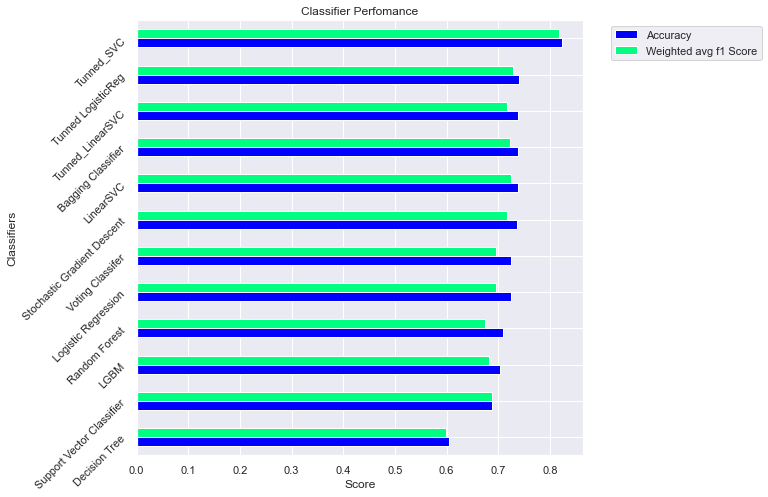

In [107]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8),colormap='winter')
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We have build a total of 11 models in this notebook out of all the models we've build, We see that the best performing model is the tunned Support Vector Classifer with the best accuracy score of 0.82 and the best weighted f1 score  of 82.

We will be using the **Support Vector Classifer** to make the final prediction.

## Final evaluation of our best model

In [108]:
print('classfication report for our best model\n',classification_report(y_val, TunedSVC.predict(X_val)))

classfication report for our best model
               precision    recall  f1-score   support

          -1       0.82      0.62      0.70       389
           0       0.78      0.58      0.66       706
           1       0.84      0.90      0.87      2559
           2       0.81      0.87      0.84      1092

    accuracy                           0.82      4746
   macro avg       0.81      0.74      0.77      4746
weighted avg       0.82      0.82      0.82      4746



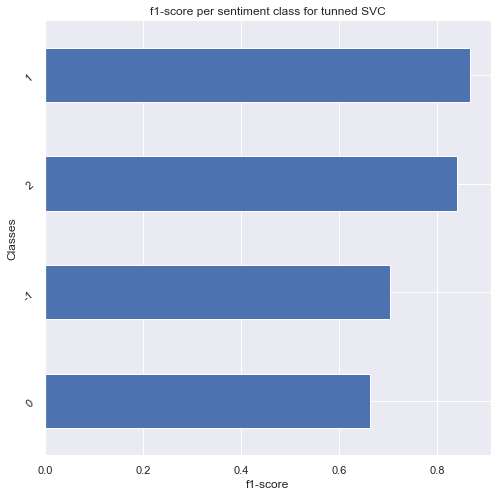

In [109]:
# # Visual represetation of of the f1 score for each class
report_tuned_svc = classification_report(y_val, TunedSVC_prediction, output_dict=True)
df_tuned_svc = pd.DataFrame(report_tuned_svc).transpose()
df_tuned_svc.drop(['accuracy'], inplace = True)
df_tuned_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tuned_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
plt.xlabel('f1-score')
plt.ylabel('Classes')
plt.yticks(rotation = 40)
plt.title('f1-score per sentiment class for tunned SVC')
plt.show()

The above bar graph shows the f1 score for each sentiment class our best model
- The Support Vector Classifier is by far our best performing model, achieving f1 score of 0.87 for `Pro climate change` sentiment class, followed by `News` and `Anti` Climate sentiment classes with f1 scores of 0.84 and 0.70 respectively, which is quite impressive given that all our models perfomed poorly when it comes to classifying `anti climate change` sentiment class


### ROC Curves and AUC

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between sentiments.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

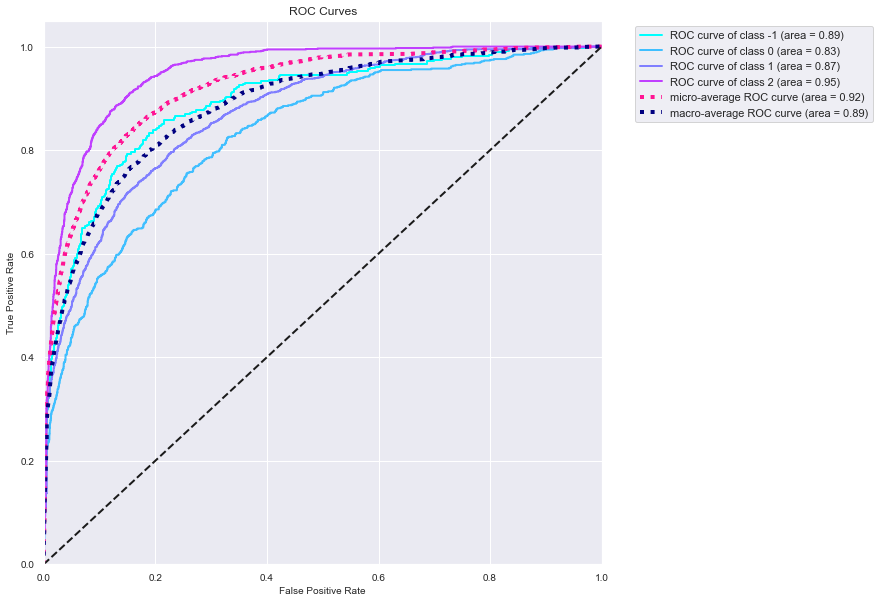

In [110]:
OneVsRest =  OneVsRestClassifier(SVC(class_weight='balanced'))
y_train_binarized = label_binarize(y_train, classes=[-1, 0, 1, 2])
y_val_binarized = label_binarize(y_val, classes=[-1, 0, 1, 2])
OneVsRest.fit(X_train_new, y_train_binarized)
y_prob = OneVsRest.decision_function(X_val_new)
plot_roc(y_val, y_prob,figsize=(10,10),cmap='cool')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<a id='predictions'></a>
# Final prediction for Kaggle submission

In [111]:
y_pred = TunedSVC.predict(X_test)

In [112]:
y_pred

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

In [113]:
#Test set predictions and saving to csv
y_test_f = TunedSVC.predict(X_test)
output = pd.DataFrame({'tweetid': test_data.tweetid,
                        'sentiment':y_test_f})
output.to_csv('submission.csv', index=False)

In [115]:
experiment.end()